In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

options(warn=-1)

options(message=-1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "kaggle-survey-2020"

In [2]:
#Import Libraries
library(reshape2)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(caret)
library(ggpubr)
library(repr)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [3]:
#Import the 2020 survey data
dat <- read.csv("../input/kaggle-survey-2020/kaggle_survey_2020_responses.csv")
dat<- dat[2:20037,]
trim <- function (x) gsub("^\\s+|\\s+$", "", x)
dat <- as.data.frame(apply(X= dat, MARGIN=2,FUN='trim'))
#head(dat,5)

In [4]:
dat1<- select(dat, Q1, Q2, Q3, Q4, Q5, Q6, Q8, Q11, Q13, Q15, Q20, Q21, Q22, Q30)
dat1<- (dat1
        %>% rename(Age = Q1, gender = Q2, country = Q3, highest.edu = Q4, current.role = Q5, exp.year = Q6)
        %>% mutate(highest.edu = substr(highest.edu, 1,4),
                   highest.edu = ifelse(highest.edu =="Doct", "Doctoral",
                                        ifelse(highest.edu =="Mast", "Masters",
                                           ifelse(highest.edu =="Bach", "Bachelors",
                                             ifelse(highest.edu =="Prof","professional",
                                                    ifelse(highest.edu =="Some", "some_college",
                                                           "NoAnswer")))))
              )
     
)

dat2<- select(dat, -Time.from.Start.to.Finish..seconds.,-Q1, -Q2, -Q3, -Q4, -Q5,
              -Q6, -Q8, -Q11, -Q13, -Q15, -Q20, -Q21, -Q22, -Q30)

#Convert to 0 or 1 for binary variables
dummies_model <- dummyVars("~.", data = dat2, fullRank = T)
dat2 <- data.frame(predict(dummies_model, newdata = dat2))
dat2 <- cbind(dat1, dat2)

#glimpse(dat2)

In [5]:
# Changing the values of USA, UK and Iran

dat2$country <- as.character(dat2$country)

dat2$country[dat2$country=="United States of America"] <- "USA"

dat2$country[dat2$country=="United Kingdom of Great Britain and Northern Ireland"] <- "UK"

dat2$country[dat2$country=="Iran, Islamic Republic of..."] <- "Iran"

In [6]:
# Changing the values of dat2$Q15 values

dat2$Q15 <- as.character(dat2$Q15)

dat2$Q15[dat2$Q15==""] <- "No Answer"
dat2$Q15[dat2$Q15=="I do not use machine learning methods"] <- "No ML Experience"

In [7]:
#unique(dat2$Q15)

In [8]:

country2 <- (dat2
           %>% group_by(country)
           %>% summarize(freq = n(), .groups = 'drop')
)

In [9]:
##################################
#Summary by country
##################################
country<- (dat2
           %>% group_by(country)
           %>% summarize(freq = n(), .groups = 'drop')
           
)

top10<- (country
         %>% filter(country != "Other")
         %>% arrange(desc(freq))
         %>% filter(row_number() <= 10)
           )

c <- unique(top10$country)

for(i in 1:length(c)){
  dat.country = filter(dat2, country == c[i])
  num.dat <-  dat.country[, sapply(dat2, class) %in% c("numeric", "integer")]
  freq <- data.frame(apply(num.dat, 2, function(x) sum(x)/nrow(num.dat)))
  freq <- rownames_to_column(freq, "var_name")
  cnt_name <- rep(c[i], nrow(freq))
  freq <- cbind(cnt_name, freq)
  names(freq) <- c("country","var_name", "Percent")
  
  if(exists('freq.all')){
    freq.all <- rbind(freq.all,freq)
  } else {
    freq.all <- freq
  }
  
}

In [10]:
######################################
#More than one Programming Language
######################################
prog_by_edu<- (dat2
         %>% mutate(prog_all = (Q7_Part_1.Python+Q7_Part_2.R+Q7_Part_3.SQL+Q7_Part_4.C+
                                   Q7_Part_5.C..+Q7_Part_6.Java+Q7_Part_7.Javascript+Q7_Part_8.Julia+
                                   Q7_Part_9.Swift+Q7_Part_10.Bash+Q7_Part_11.MATLAB+Q7_Part_12.None+Q7_OTHER.Other),
                    prog_1 = ifelse(prog_all == 1, 1, 0),
                    prog_2 = ifelse(prog_all == 2, 1, 0),
                    prog_3 = ifelse(prog_all == 3, 1, 0),
                    prog_4 = ifelse(prog_all == 4, 1, 0),
                    prog_5 = ifelse(prog_all == 5, 1, 0))
         %>% group_by(highest.edu)
         %>% summarize(prog_1 = sum(prog_1),
                       prog_2 = sum(prog_2),
                       prog_3 = sum(prog_3),
                       prog_4 = sum(prog_4),
                       prog_5 = sum(prog_5), .groups = 'drop')
         
         )

In [11]:
# Filter out highest.edu = "NoAnswer"

prog_by_edu <- prog_by_edu %>%
filter (!highest.edu == "NoAnswer")

#unique(prog_by_edu$highest.edu)

#  <span style='color:purple'>Kaggle Community Survey Exploration</span>

<div style="text-align: justify;
             font-size:18px">
Objective of this visualization story is to provide general profile of all respondents of <span style='color:purple'> 2020 Kaggle Machine Learning and Data Science Survey</span>, and deeply explore the gender dynamics in all countries, education level, age range with focus on use of programming languages, visualization tools and machine learning algorithms. This report is extended to focus on women respondents and respondents from United States only. Key survey items are presented in the table below.                </div>



| <font size="4">Key Survey Items</font>| <font size="4">Counts</font>|
| :- | :- | 
| <font size="4">Total Respondents</font>| <font size="4">20,036</font>
| <font size="4">Total questions</font> | <font size="4">355</font>
|  |   | 
| <font size="4">Single option questions</font> | <font size="4">19</font> 
|  |   | 
| <font size="4">Men</font> | <font size="4">15,789 </font> 
|  |   | 
| <font size="4">Women</font> | <font size="4">3,878 </font>
|  |   | 
|<font size="4">Countries</font>| <font size="4">55</font>
|    |    | 
| <font size="4">Respondent's professions</font> | <font size="4">13</font>

<div style="text-align: justify;
             font-size:18px">                                                          
In the survey, there are two types of questions: questions with single option selection and matrix type questions where respondents could pick multiple answers. Therefore, the percentage total from individual components on some visualizations may exceed 100%.
                             
</div>

# <span style='color:purple'> Outline </span>


  - <font size="5">Overview of Kaggle Users</font>
  - <font size="5">Gender dynamics</font>
  - <font size="5">Women in Kaggle</font>
  - <font size="5">Inside the United States</font>
  - <font size="5">Conclusion</font>   


# <span style='color:purple'> Overview of Kaggle Users </span>

<div style="text-align: justify;
       font-size:20px">
In terms of age group, kaggle participants are pretty diverse with majority of younger adults in all countries.
Surprisingly some countries such as India, Nepal, Indonesia, and Vietnam have users of age 18-21 more than 25% of their total users. 
On the otherhand, older adults are mostly from countries like USA, UK, Japan, Italy, Canada, France, Belgium, Netherlands, Portugal, Australia etc. 
 </div>

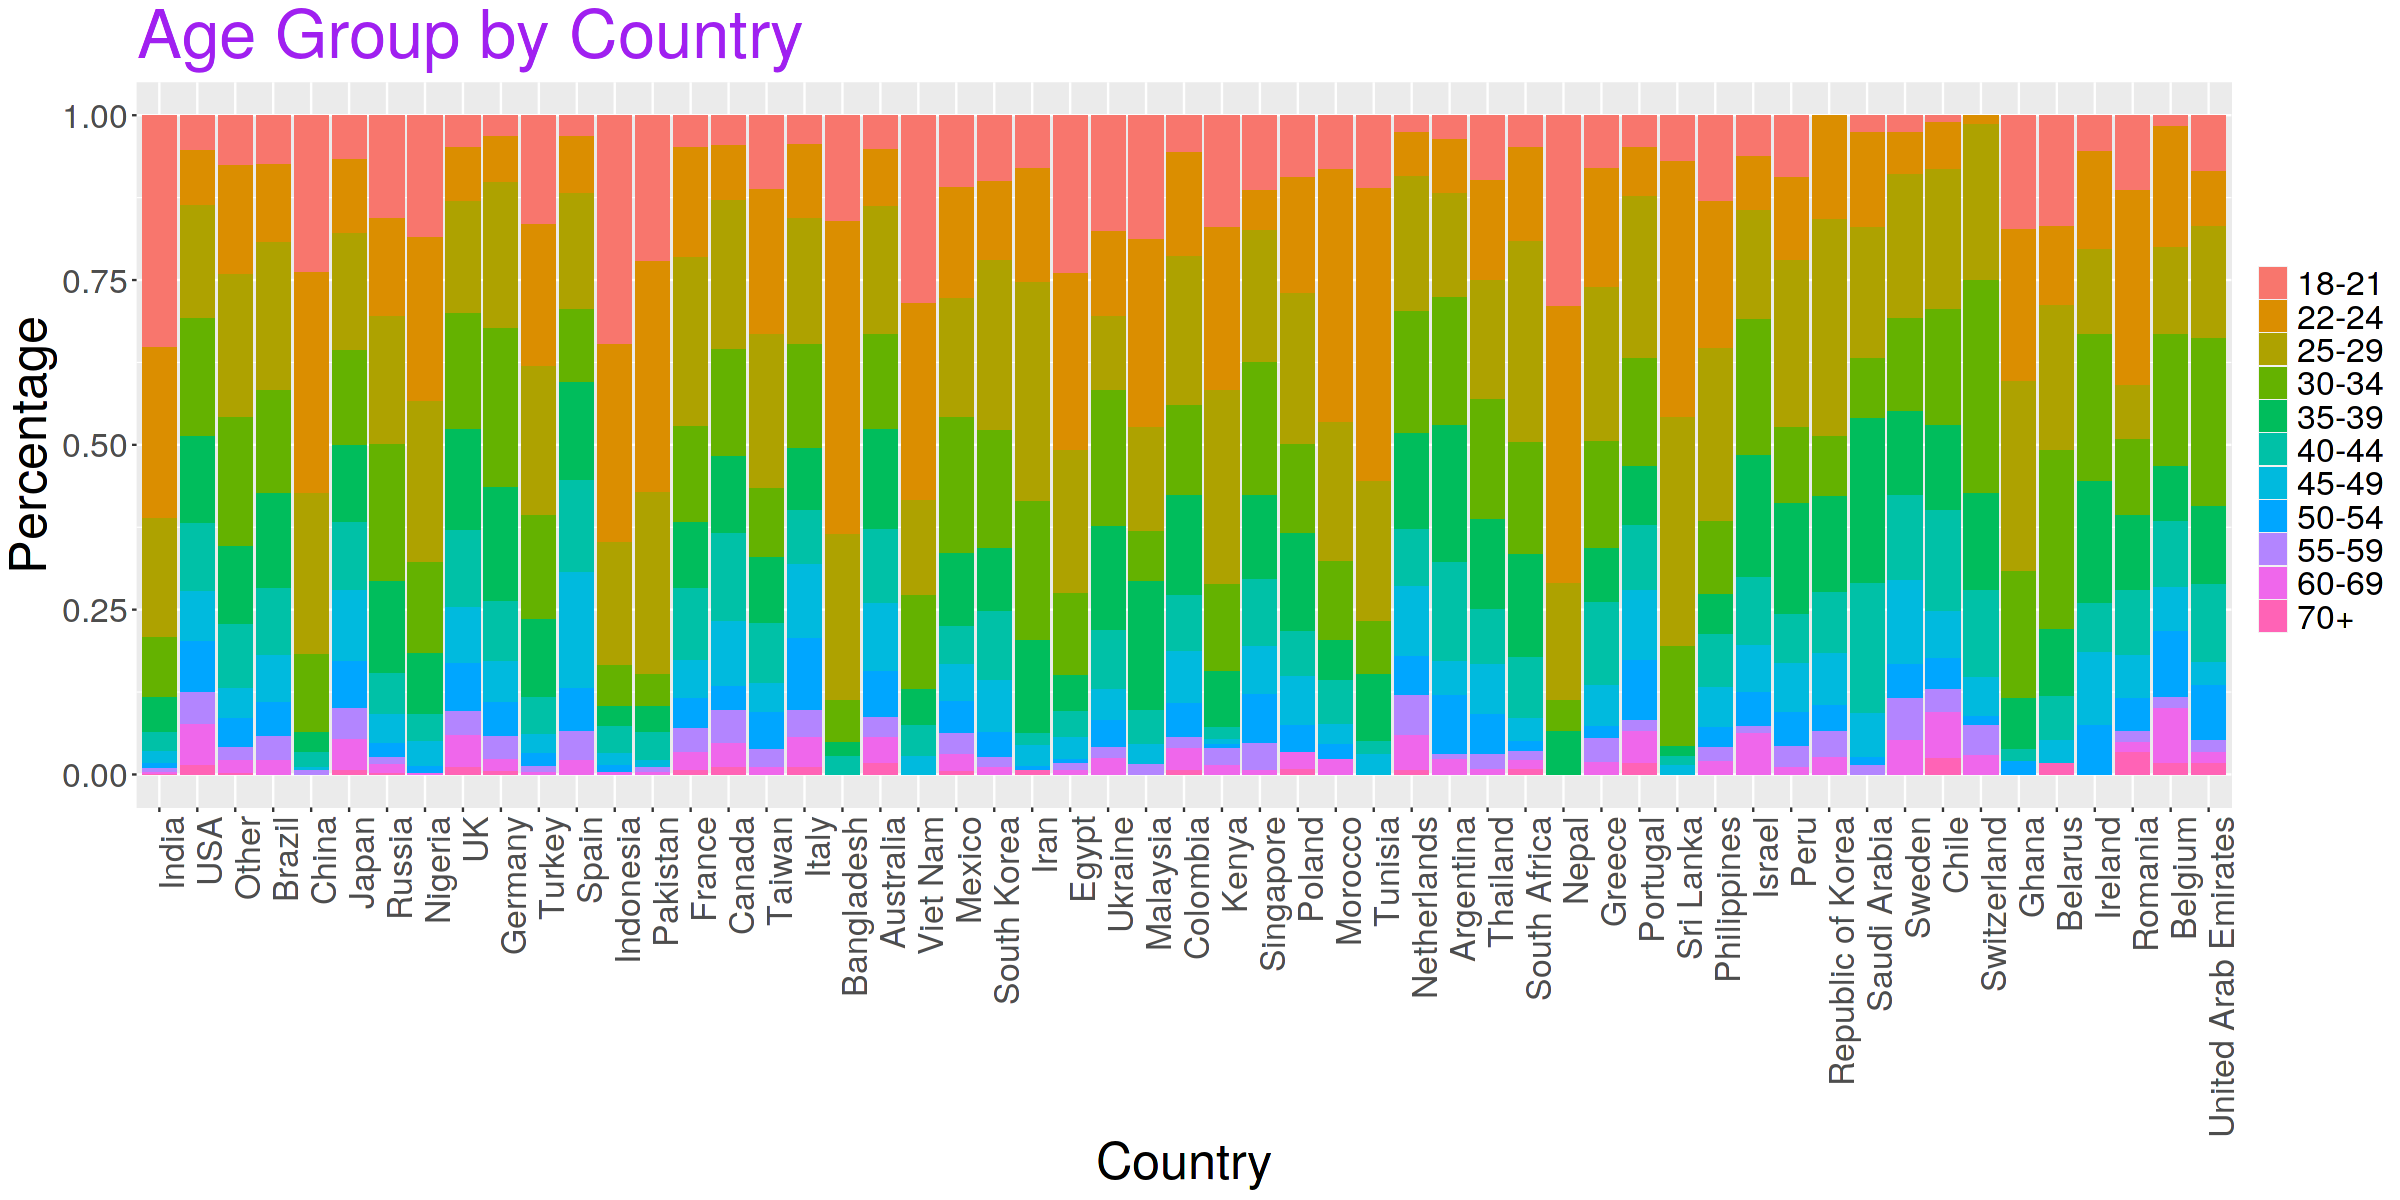

In [12]:
options(repr.plot.width = 20, repr.plot.height = 10)

#########################################
#Age Group and country
#########################################
age_by_country<- (dat2
                  %>% group_by(country, Age)
                  %>% summarize(participants = n(), .groups = 'drop')
                        %>% left_join(., country2, by="country")
                  %>% mutate(percent = participants/freq)
                  #%>% filter(country %in% c)
                  
            )


plot1 <- ggplot(age_by_country, aes(fill=Age, y=percent, x=reorder(country, -participants))) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Country",y="Percentage")+
  ggtitle("Age Group by Country") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
    #legend.position = c(.95, .95),
    legend.text = element_text(size = 20),
    axis.text.x = element_text(angle = 90, hjust = 1))
plot1

 <div style="text-align: justify;
       font-size:20px">
Kagglers are using various languages. Python is the most popular language with over 3 in 4 users. SQL and R are next popular languages with 38% and 21% users, respectively. 
 </div>

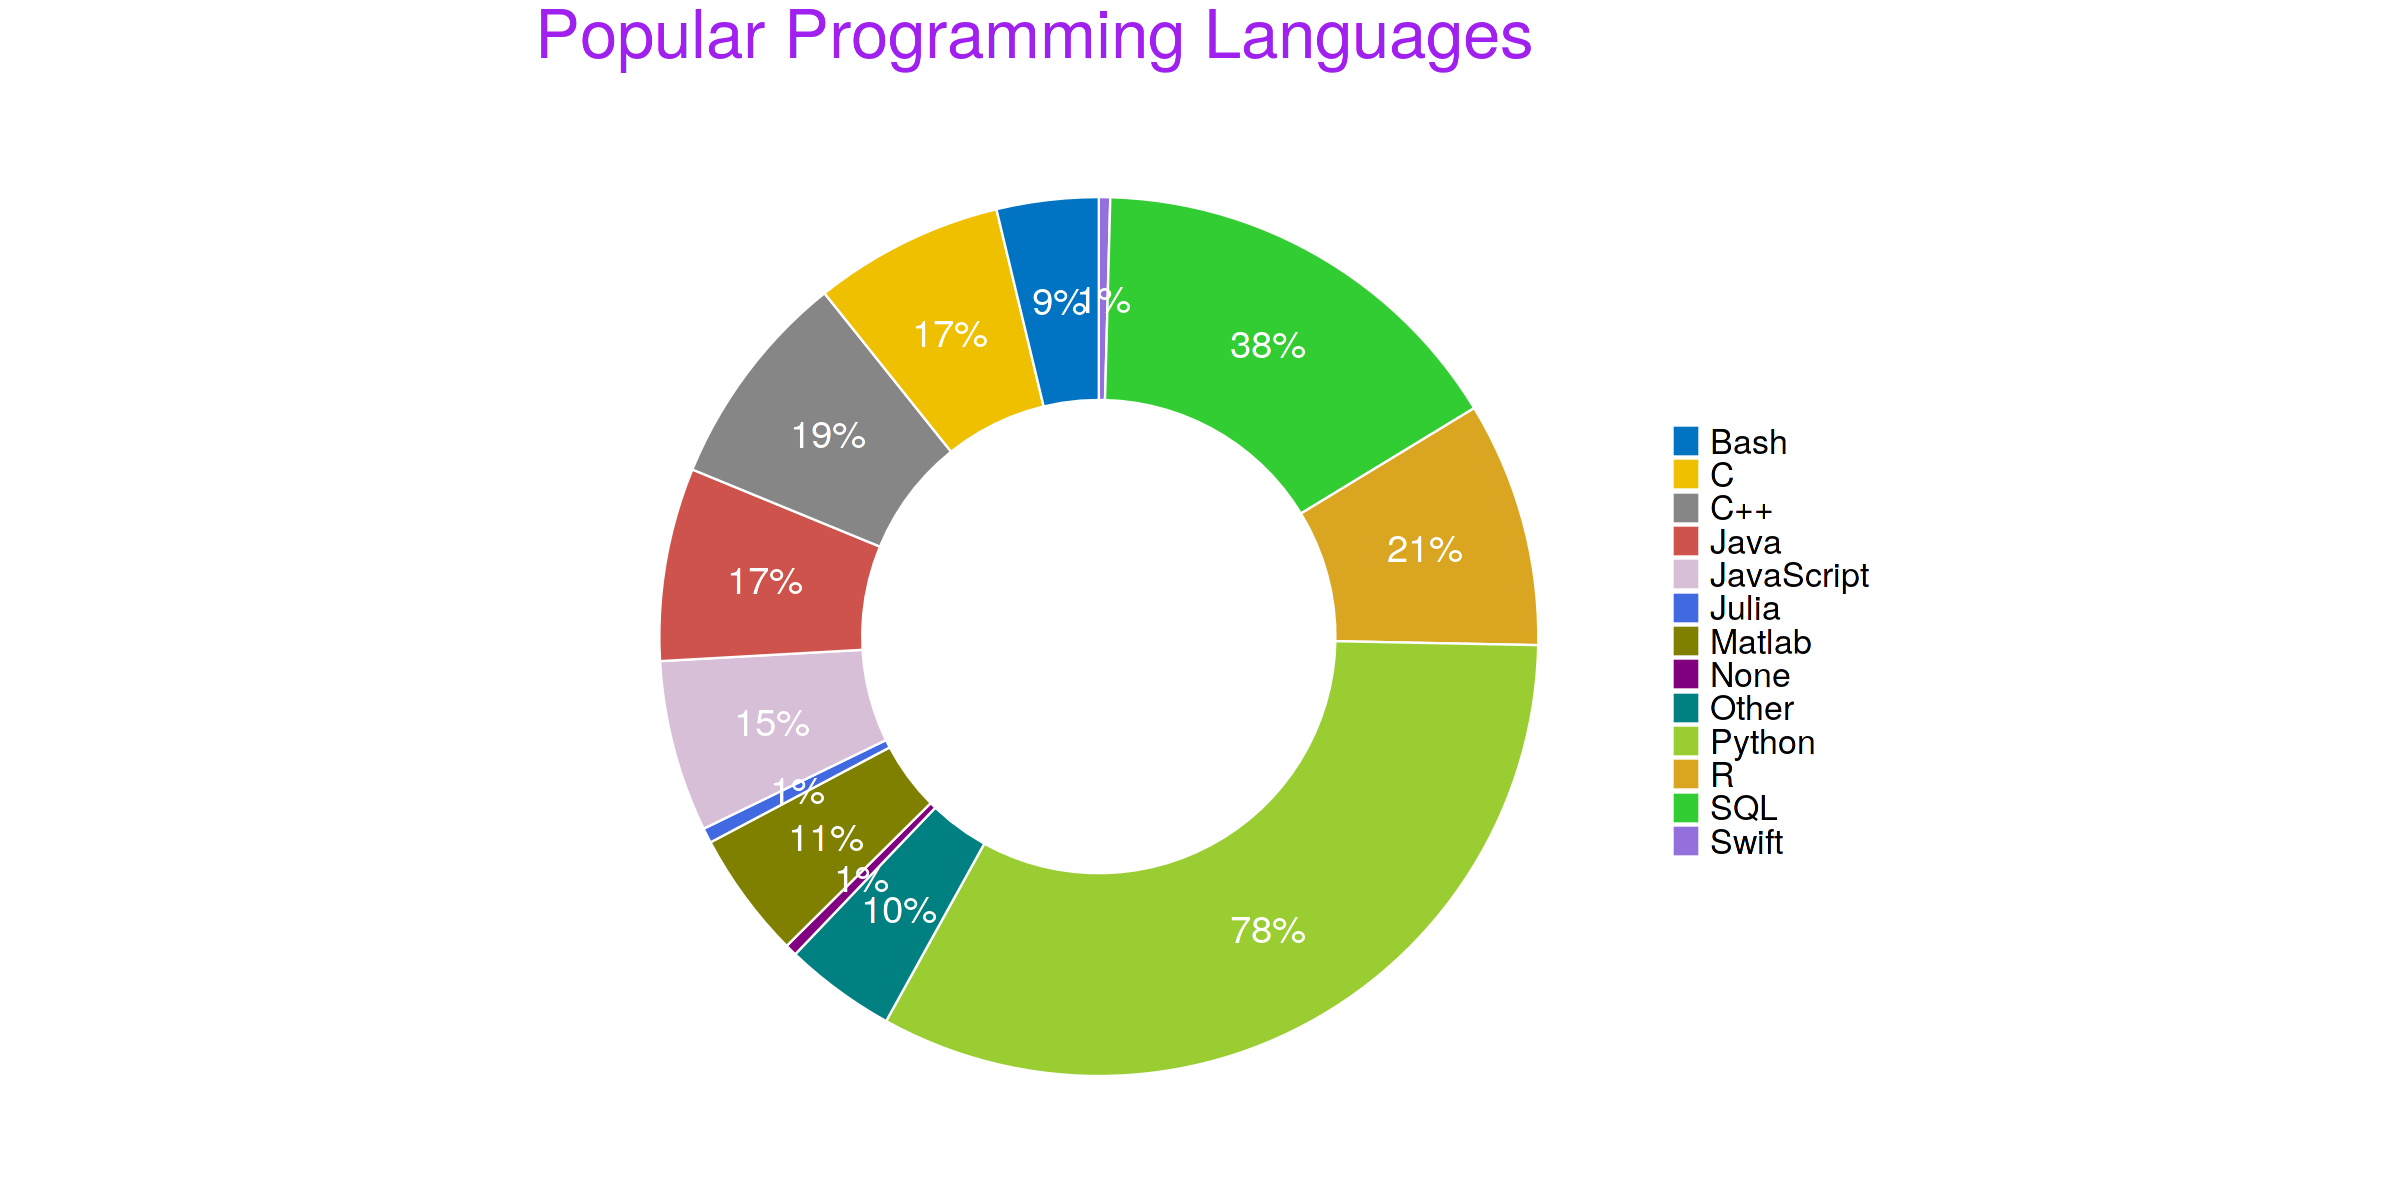

In [13]:
####################################
#Summary by data columns
####################################
options(repr.plot.width = 20, repr.plot.height = 10)

num.dat <- dat2[, sapply(dat2, class) %in% c("numeric", "integer")]
freq <- data.frame(apply(num.dat, 2, function(x) sum(x)/nrow(num.dat)))
freq <- add_rownames(freq, "var_name")
names(freq) <- c("var_name", "Percent")

#Programming Language use
prog.lang<- freq[1:13,]
prog_lang<- c("Python", "R", "SQL", "C", "C++","Java", "JavaScript", "Julia",
                     "Swift", "Bash", "Matlab", "None", "Other")
prog.lang<- cbind(prog_lang, prog.lang)


                         
#Donut chart
prog.lang <- prog.lang %>%
  arrange(desc(prog_lang)) %>%
  mutate(lab.ypos = cumsum(Percent) - 0.5*Percent)


mycols <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#D8BFD8","#4169E1",
            "#808000", "#800080", "#008080", "#9ACD32", "#DAA520", "#32CD32", "#9370DB")
ggplot(prog.lang, aes(x = 2, y = Percent, fill = prog_lang)) + 
  
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0)+
  geom_text(aes(y = lab.ypos, label = paste0(round(Percent*100,0), "%")), size =8, color = "white")+
  scale_fill_manual(values = mycols) +

  ggtitle("Popular Programming Languages")+                        
  theme_void()+
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'))+
  xlim(0.5, 2.5)+
    theme(
    legend.text = element_text(size = 20),
    legend.title = element_blank())

<div style="text-align: justify;
       font-size:20px">
In all education levels, majority of participants know about 2 different programming languages. Small but significant fraction of participants use five programming languages. 
 </div>

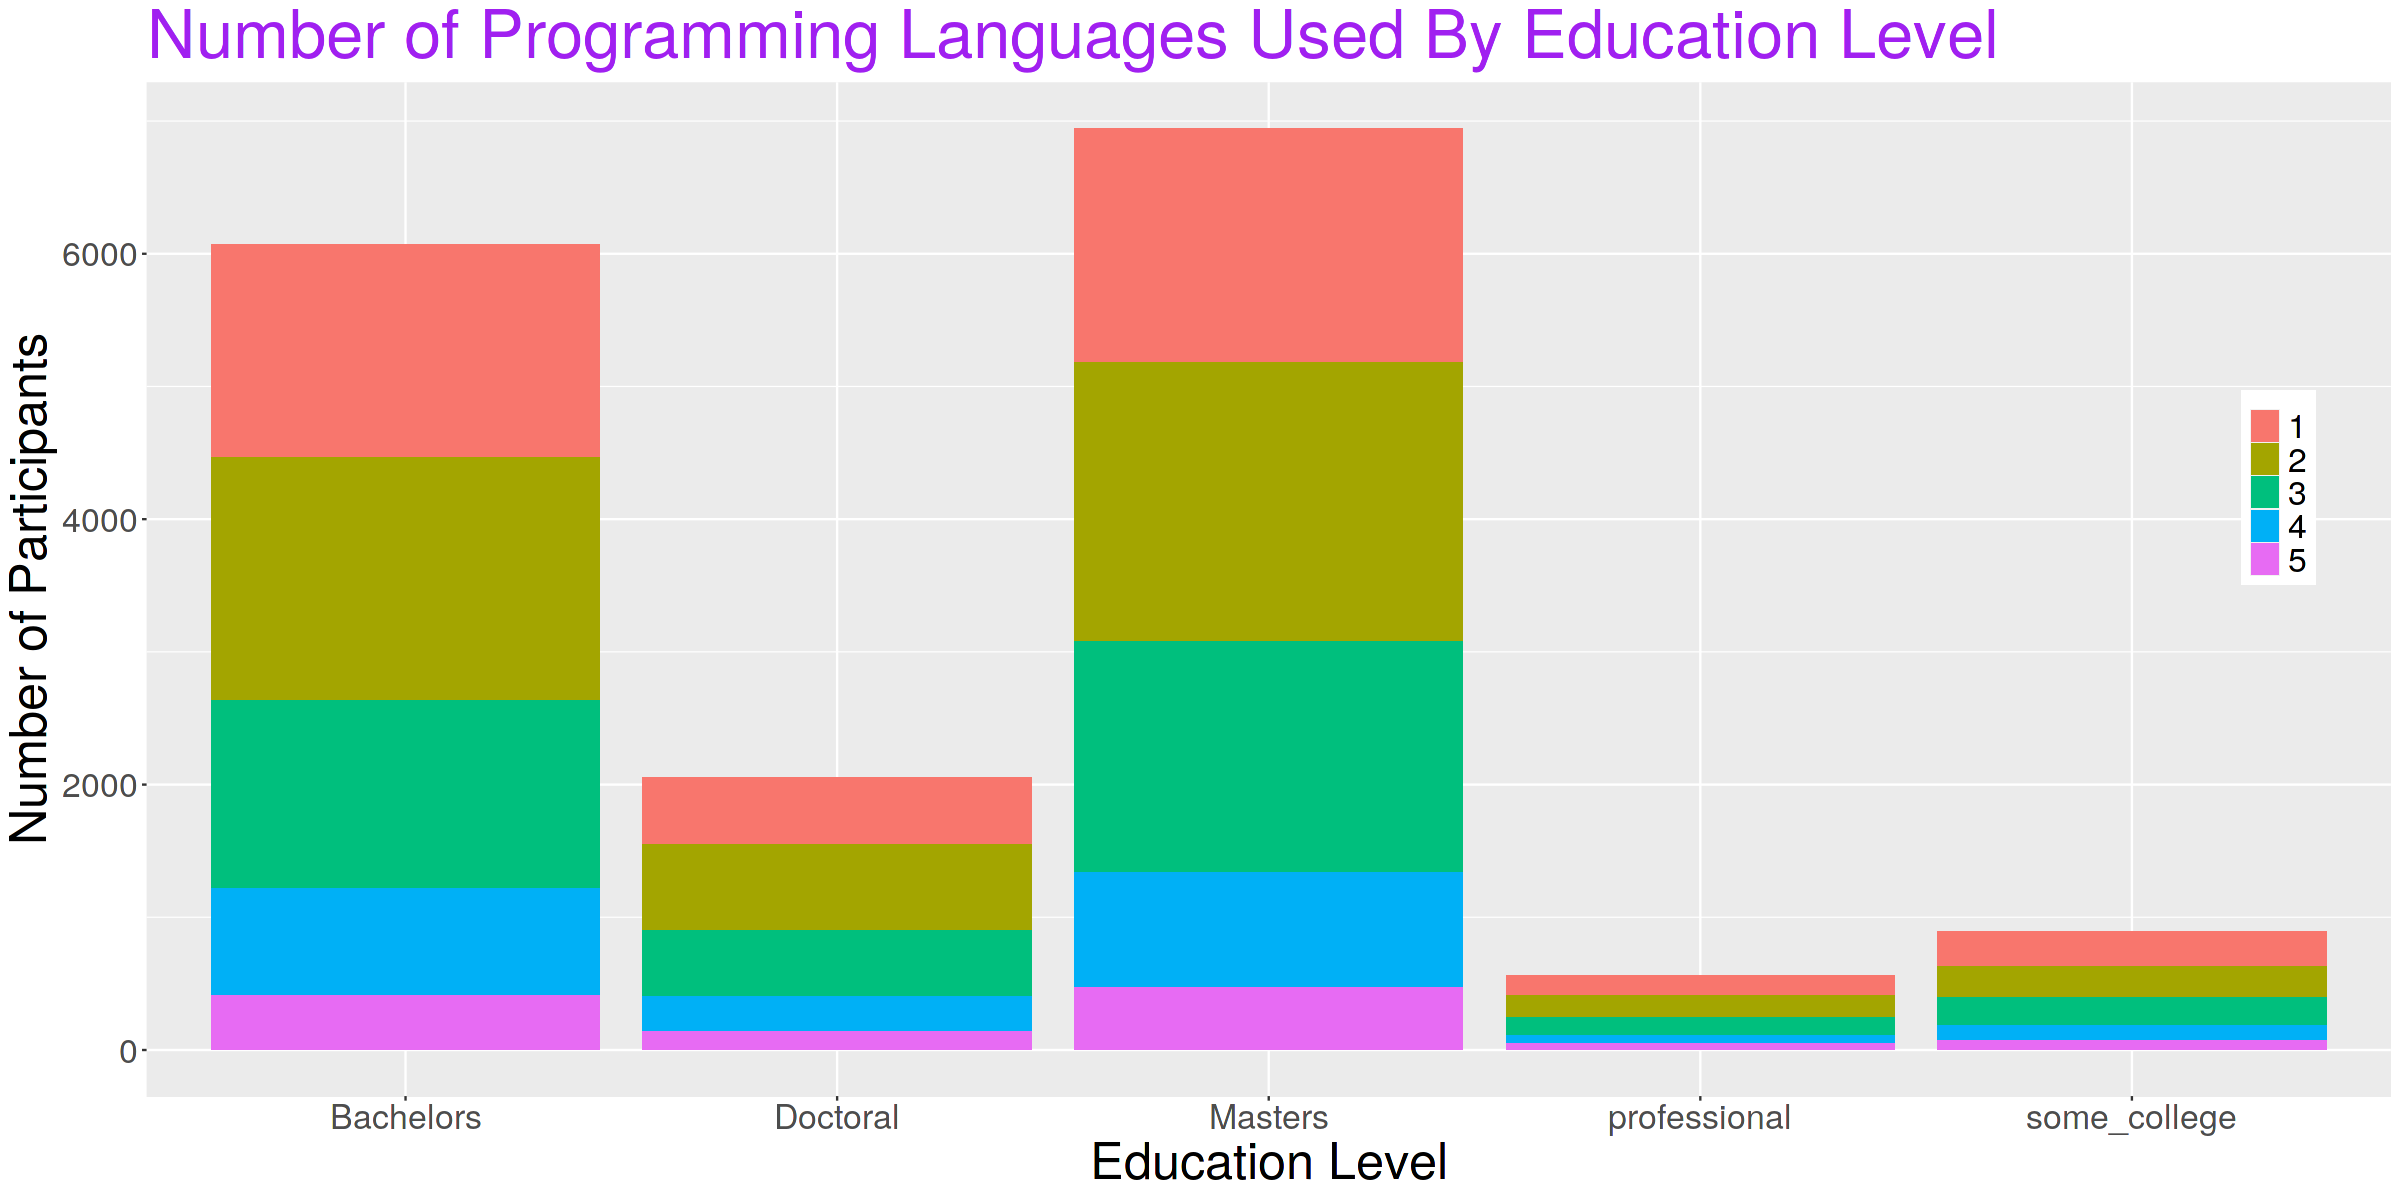

In [14]:
options(repr.plot.width = 20, repr.plot.height = 10)



#Stacked BarPlot 
prog_by_edu<- melt(prog_by_edu, id = c("highest.edu"))
prog_by_edu$Num <- substr(prog_by_edu$variable, 6,7)


ggplot(prog_by_edu, aes(fill=Num, y=value, x=highest.edu)) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Education Level",y="Number of Participants")+
  ggtitle("Number of Programming Languages Used By Education Level") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
       axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
        legend.position = c(0.95, 0.6),
        legend.text = element_text(size = 20))

In [15]:
#Number of Programming Language Used in top 10 countries
prog_by_country<- (dat2
               %>% mutate(prog_all = (Q7_Part_1.Python+Q7_Part_2.R+Q7_Part_3.SQL+Q7_Part_4.C+
                                   Q7_Part_5.C..+Q7_Part_6.Java+Q7_Part_7.Javascript+Q7_Part_8.Julia+
                                   Q7_Part_9.Swift+Q7_Part_10.Bash+Q7_Part_11.MATLAB+Q7_Part_12.None+Q7_OTHER.Other),
                          prog_1 = ifelse(prog_all == 1, 1, 0),
                          prog_2 = ifelse(prog_all == 2, 1, 0),
                          prog_3 = ifelse(prog_all == 3, 1, 0),
                          prog_4 = ifelse(prog_all == 4, 1, 0),
                          prog_5 = ifelse(prog_all > 4, 1, 0))
               %>% group_by(country)
               %>% summarize(prog_1 = sum(prog_1),
                             prog_2 = sum(prog_2),
                             prog_3 = sum(prog_3),
                             prog_4 = sum(prog_4),
                             prog_5 = sum(prog_5), .groups = 'drop')               
)

In [16]:
#Changing country to factor variable

prog_by_country$country <- as.factor(prog_by_country$country)


 <div style="text-align: justify;
       font-size:20px">
The fraction of participants with knowledge of number of languages is pretty constant on majority of countries. Some countries with significant fraction of 
participants using five programming languages are Morocco, Tunisia, Sri Lanka and Peru.
 </div>

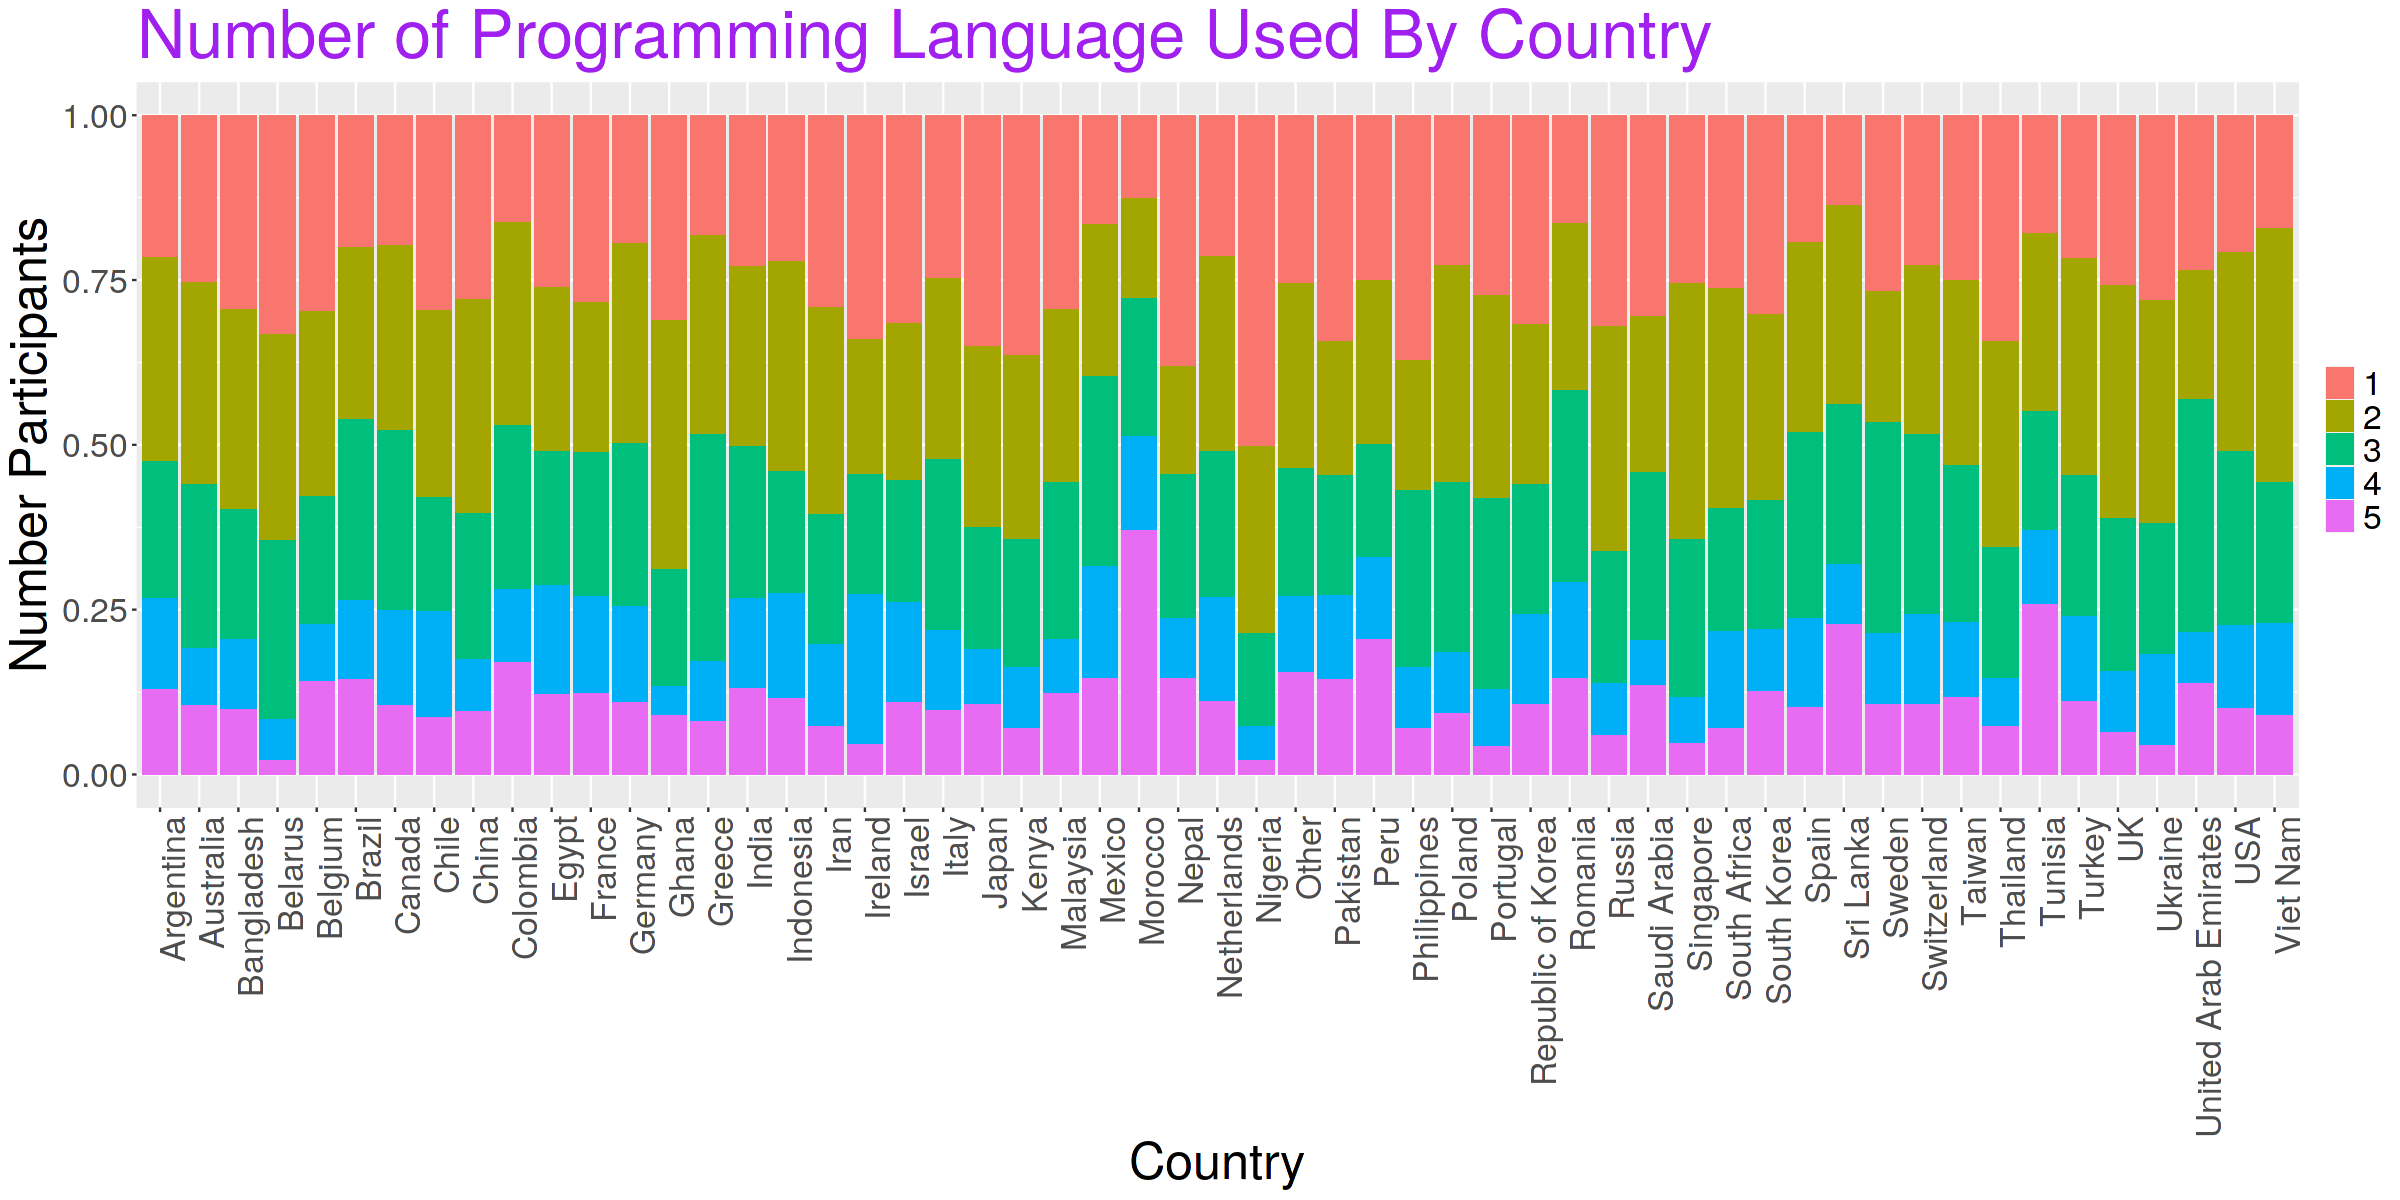

In [17]:
#Plot 
options(repr.plot.width = 20, repr.plot.height = 10)
prog_by_country<- melt(prog_by_country, id = c("country"))
prog_by_country$Num <- substr(prog_by_country$variable, 6,7)
prog_by_country1<- prog_by_country%>% group_by(country)%>% summarise(sum=sum(value), .groups = 'drop')%>%ungroup()
prog_by_country<- prog_by_country%>% left_join(.,prog_by_country1, by="country")%>% mutate(value= value/sum)


ggplot(prog_by_country, aes(fill=Num, y=value, x=country)) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Country",y="Number Participants")+
  ggtitle("Number of Programming Language Used By Country") +
  theme(legend.title = element_blank(),
        #legend.position = c(0.95, 0.75),
        legend.text = element_text(size = 20),
        axis.text.x = element_text(angle = 90, hjust = 1))+
        theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
            axis.text.x = element_text(size = 20, family = 'Times new Roman'),
            axis.text.y = element_text(size = 20, family = 'Times new Roman'),
            axis.title.x = element_text(size = 30, family = 'Times new Roman'),
            axis.title.y = element_text(size = 30, family = 'Times new Roman'))

<div style="text-align: justify;
       font-size:20px">
Matplotlib and Seaborn visulization libraries are most popular with 62% and 44% users. Users of ggplot and plotly are equal which is 21%. About 9% of respondents do not use any visualization libraries at all.
 </div>

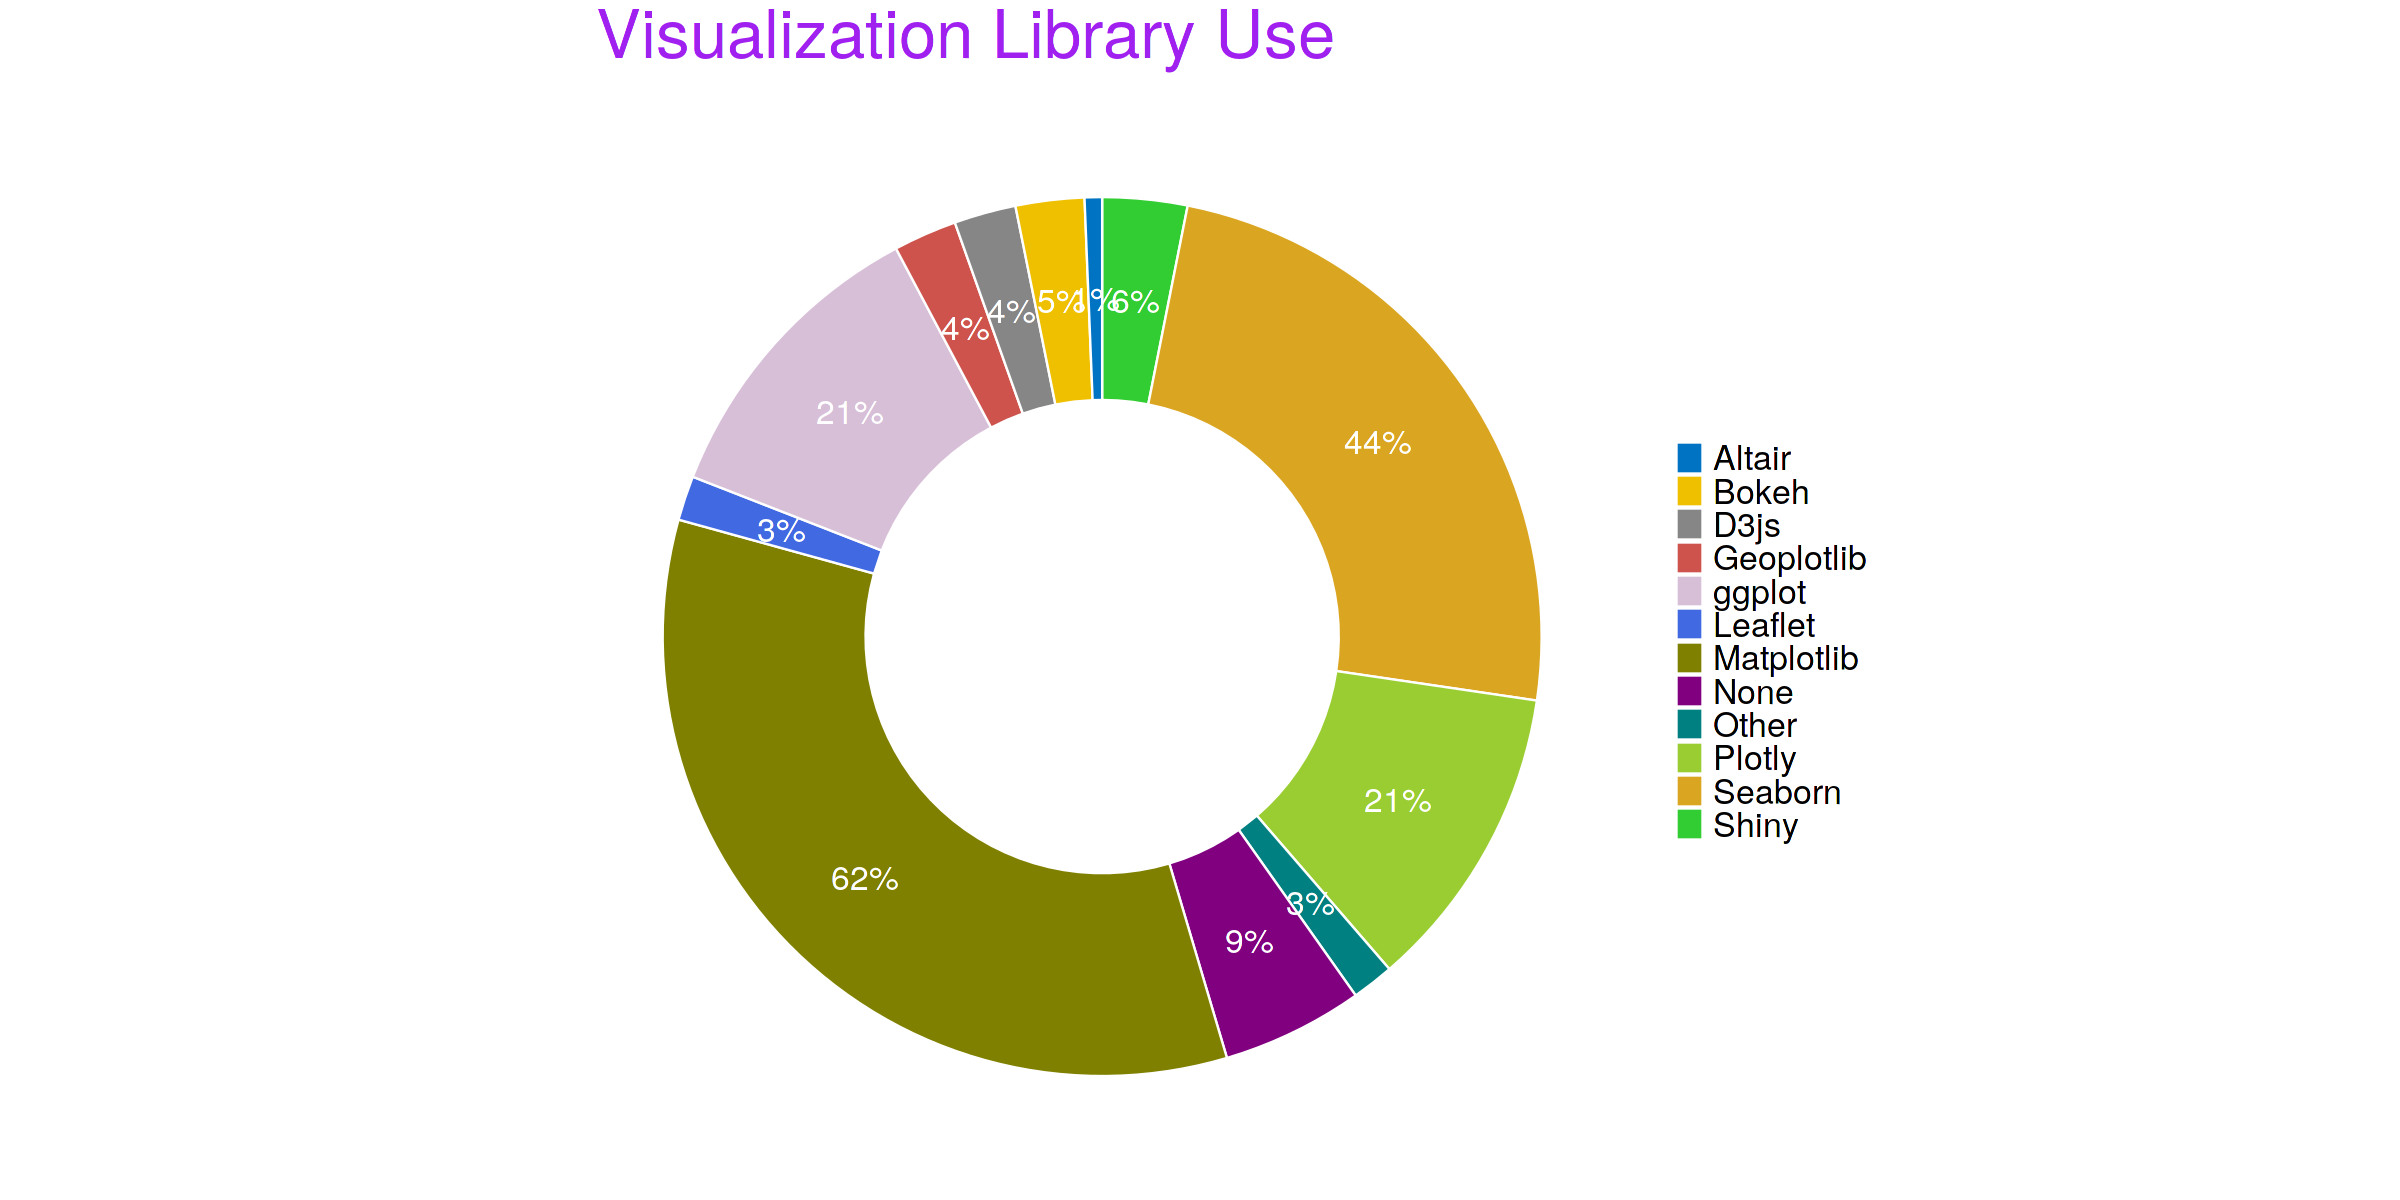

In [18]:
options(repr.plot.width = 20, repr.plot.height = 10)
#Programming Platform use
prog.platform <- freq[14:25,]
platform_name<- c("Jupyter", "Rstudio", "Visualstudio", "VScode", "Pycharm", "Spyder", 
                         "Notepadplus", "Sublime_Text", "Vim_Emacs", "Matlab", "None",  "Other")   
prog.platform<- cbind(platform_name,prog.platform)

#Hosted Notebook use
hosted.notebook<- freq[26:39,]
hosted.notebook_name<- c("Kaggle", "Colab", "Azure", "Gradient", "Binder", "Codeclean",
                           "IBMstudio", "Amazonsage", "Amazonemr", "Googlecloud_ai", "Googlecloud_datalab",
                           "DataBrick", "None", "Other")
hosted.notebook<- cbind(hosted.notebook_name, hosted.notebook)

#Visualization library use
viz.lib<- freq[44:55,]
viz.lib_name<- c("Matplotlib", "Seaborn", "Plotly", "ggplot", "Shiny", "D3js", "Altair", 
                  "Bokeh","Geoplotlib", "Leaflet", "None", "Other")
viz.lib<- cbind(viz.lib_name, viz.lib)

#Donut chart
viz.lib <- viz.lib %>%
  arrange(desc(viz.lib_name)) %>%
  mutate(lab.ypos = cumsum(Percent) - 0.5*Percent)


mycols <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#D8BFD8","#4169E1",
            "#808000", "#800080", "#008080", "#9ACD32", "#DAA520", "#32CD32", "#9370DB")
ggplot(viz.lib, aes(x = 2, y = Percent, fill =viz.lib_name)) +
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0)+
  geom_text(aes(y = lab.ypos, label = paste0(round(Percent*100,0), "%")),  size = 7, color = "white")+
  scale_fill_manual(values = mycols) +
  theme_void()+ xlim(0.5, 2.5)+
  ggtitle("   Visualization Library Use")+
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'))+
  #xlim(0.5, 2.5)+
    theme(
    legend.text = element_text(size = 20),
    legend.title = element_blank())


<div style="text-align: justify;
       font-size:20px">
Linear and Logistic regression were most commonly used algorithms followed by tree based models for all experience level.
 </div>

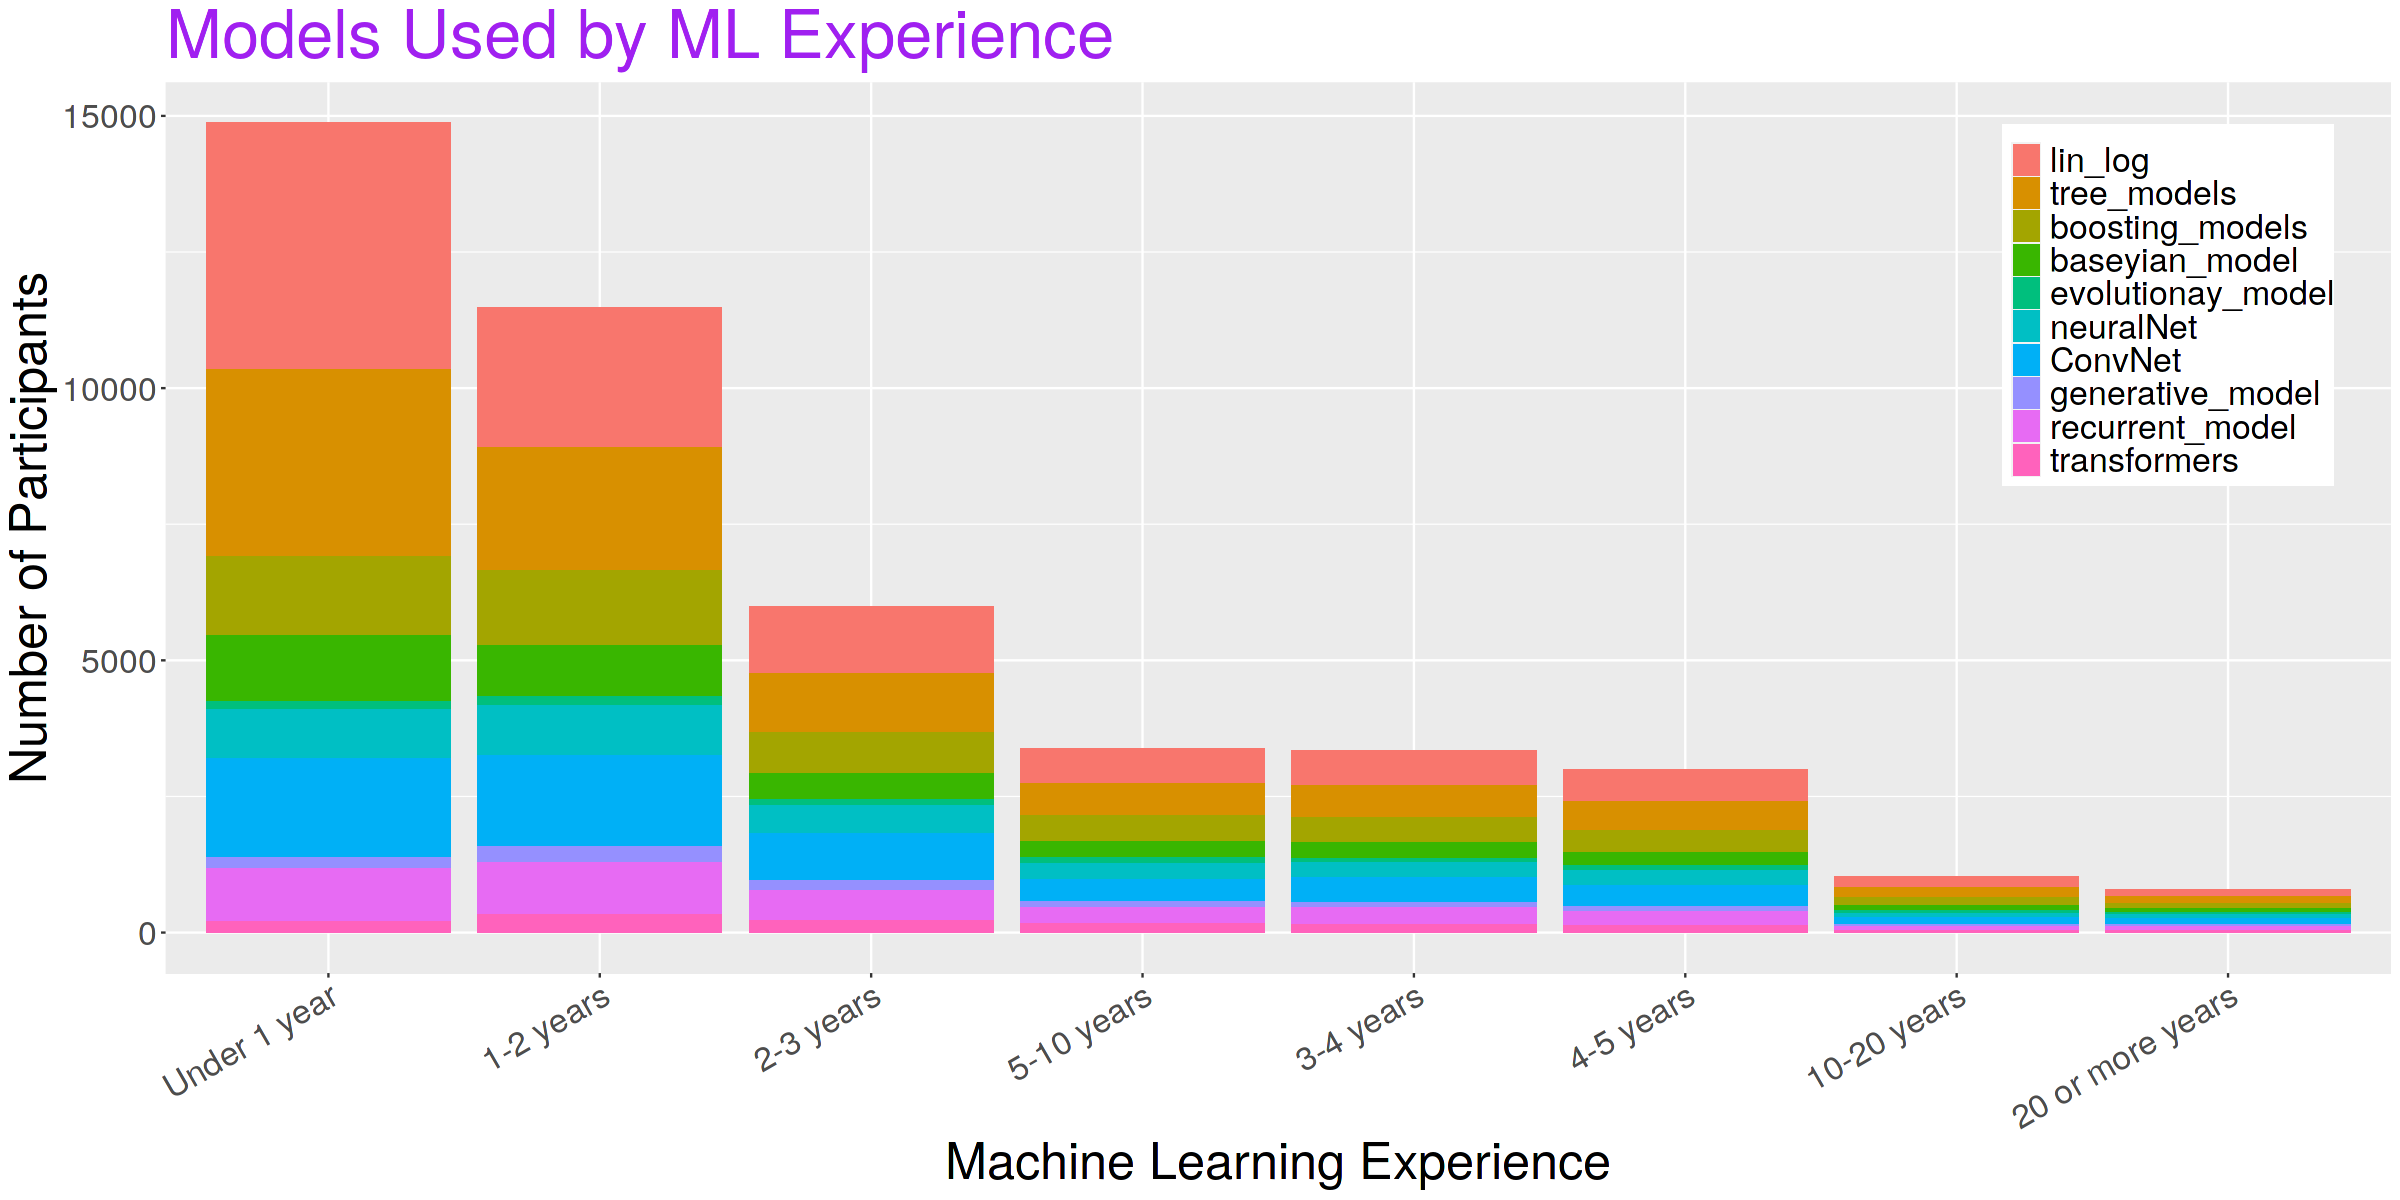

In [19]:
options(repr.plot.width = 20, repr.plot.height = 10)
#ML use Experience and model use

ml_model<- (dat2
            %>% group_by(Q15)
            %>% summarise(lin_log = sum(Q17_Part_1.Linear.or.Logistic.Regression),
                          tree_models = sum(Q17_Part_2.Decision.Trees.or.Random.Forests),
                          boosting_models = sum(Q17_Part_3.Gradient.Boosting.Machines..xgboost..lightgbm..etc.),
                          baseyian_model = sum(Q17_Part_4.Bayesian.Approaches),
                          evolutionay_model = sum(Q17_Part_5.Evolutionary.Approaches),
                          neuralNet = sum(Q17_Part_6.Dense.Neural.Networks..MLPs..etc.),
                          ConvNet = sum(Q17_Part_7.Convolutional.Neural.Networks),
                          generative_model = sum(Q17_Part_8.Generative.Adversarial.Networks),
                          recurrent_model = sum(Q17_Part_9.Recurrent.Neural.Networks),
                          transformers = sum(Q17_Part_10.Transformer.Networks..BERT..gpt.3..etc.),
                          .groups = 'drop'
                          )
            # %>% mutate(Q15 = ifelse(Q15 == "", "No Answer",
            #                         ifelse(Q15 =="I do not use machine learning methods", "No ML Experience", Q15)))
            %>% ungroup()
            %>% filter(Q15 != "" & Q15 != "I do not use machine learning methods")
            %>% filter(!Q15 %in% c("No Answer","No ML Experience"))
            )


ml_model<- melt(ml_model, id = "Q15")
names(ml_model)<- c("ML_Exp", "Models_used", "value")

ggplot(ml_model, aes(fill=Models_used, y=value, x=reorder(ML_Exp, -value))) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Machine Learning Experience",y="Number of Participants")+
  ggtitle("Models Used by ML Experience") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
    legend.position = c(0.90, 0.75),
    legend.text = element_text(size = 20),
    axis.text.x = element_text(angle = 30, hjust = 1))



<div style="text-align: justify;
       font-size:20px">

 </div>

# <span style='color:purple'> Gender Dynamics </span>


<div style="text-align: justify;
       font-size:20px">
There is heavy gender gap among kaggle users in all participant countries. Among top 10 countries in terms of number of participants, Turkey and India are ahead of United States in terms of closing the gender gap while Japan has the largest gap.
 </div>

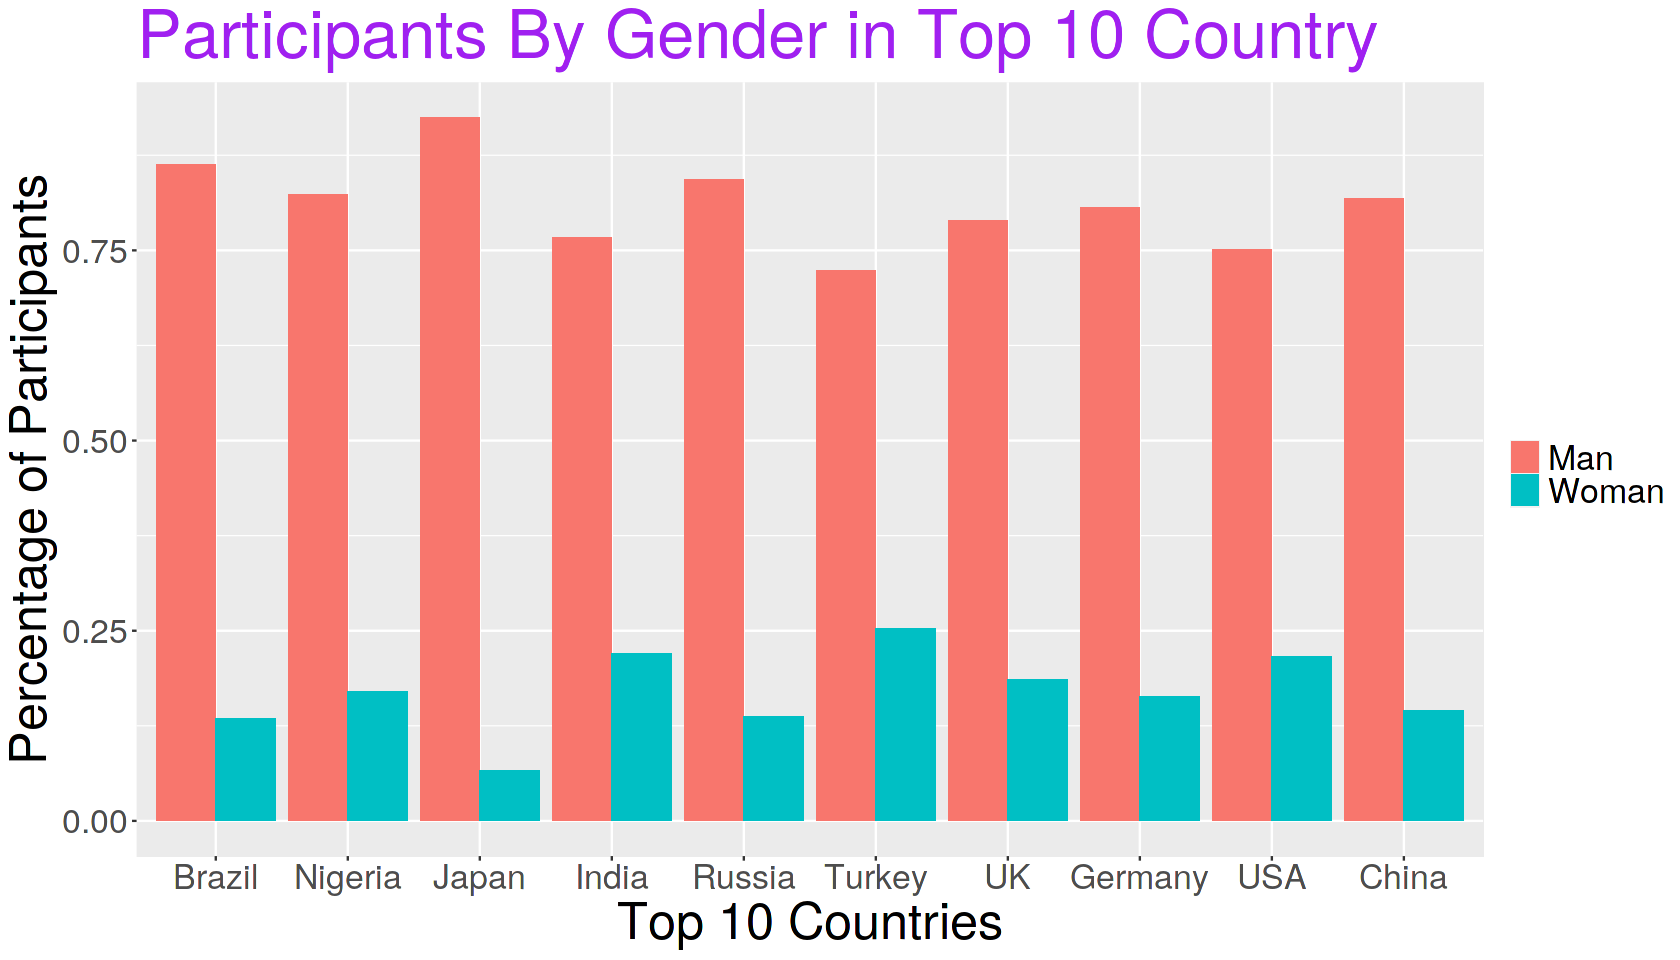

In [20]:
####################################################
#Gender Analysis
####################################################
options(repr.plot.width = 20, repr.plot.height = 10)
## Gender by country
gender_by_country<- (dat2
                     
                     %>% group_by(country, gender)
                     %>% summarize(participants = n(),.groups = 'drop' )
                     %>% filter(country %in% c & gender %in% c("Man", "Woman"))
                     %>% left_join(., country2, by="country")
                     %>% mutate(percent = participants/freq)
                     %>% rename(Gender = gender)
)

options(repr.plot.width = 14, repr.plot.height = 8)

ggplot(gender_by_country, aes(fill=Gender, y=percent, x=reorder(country, -percent))) + 
  geom_bar(position="dodge", stat="identity")+
  labs(x="Top 10 Countries",y="Percentage of Participants")+
  ggtitle("Participants By Gender in Top 10 Country") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
    #legend.position = c(0.95, 0.75),
    legend.text = element_text(size = 20))


In [21]:
####################################
#Participants by country
####################################
country<- (dat2 %>%
           filter(gender %in% c("Man","Woman")) 
           %>% group_by(country, gender)
           %>% summarize(freq = n(), .groups = 'drop')
           
)


In [22]:
head(country)

country,gender,freq
<chr>,<fct>,<int>
Argentina,Man,111
Argentina,Woman,20
Australia,Man,182
Australia,Woman,38
Bangladesh,Man,118
Bangladesh,Woman,24


<div style="text-align: justify;
       font-size:20px">
Looking at the world map, majority of participants for both men and women are from India followed by from the United States. 
 </div>

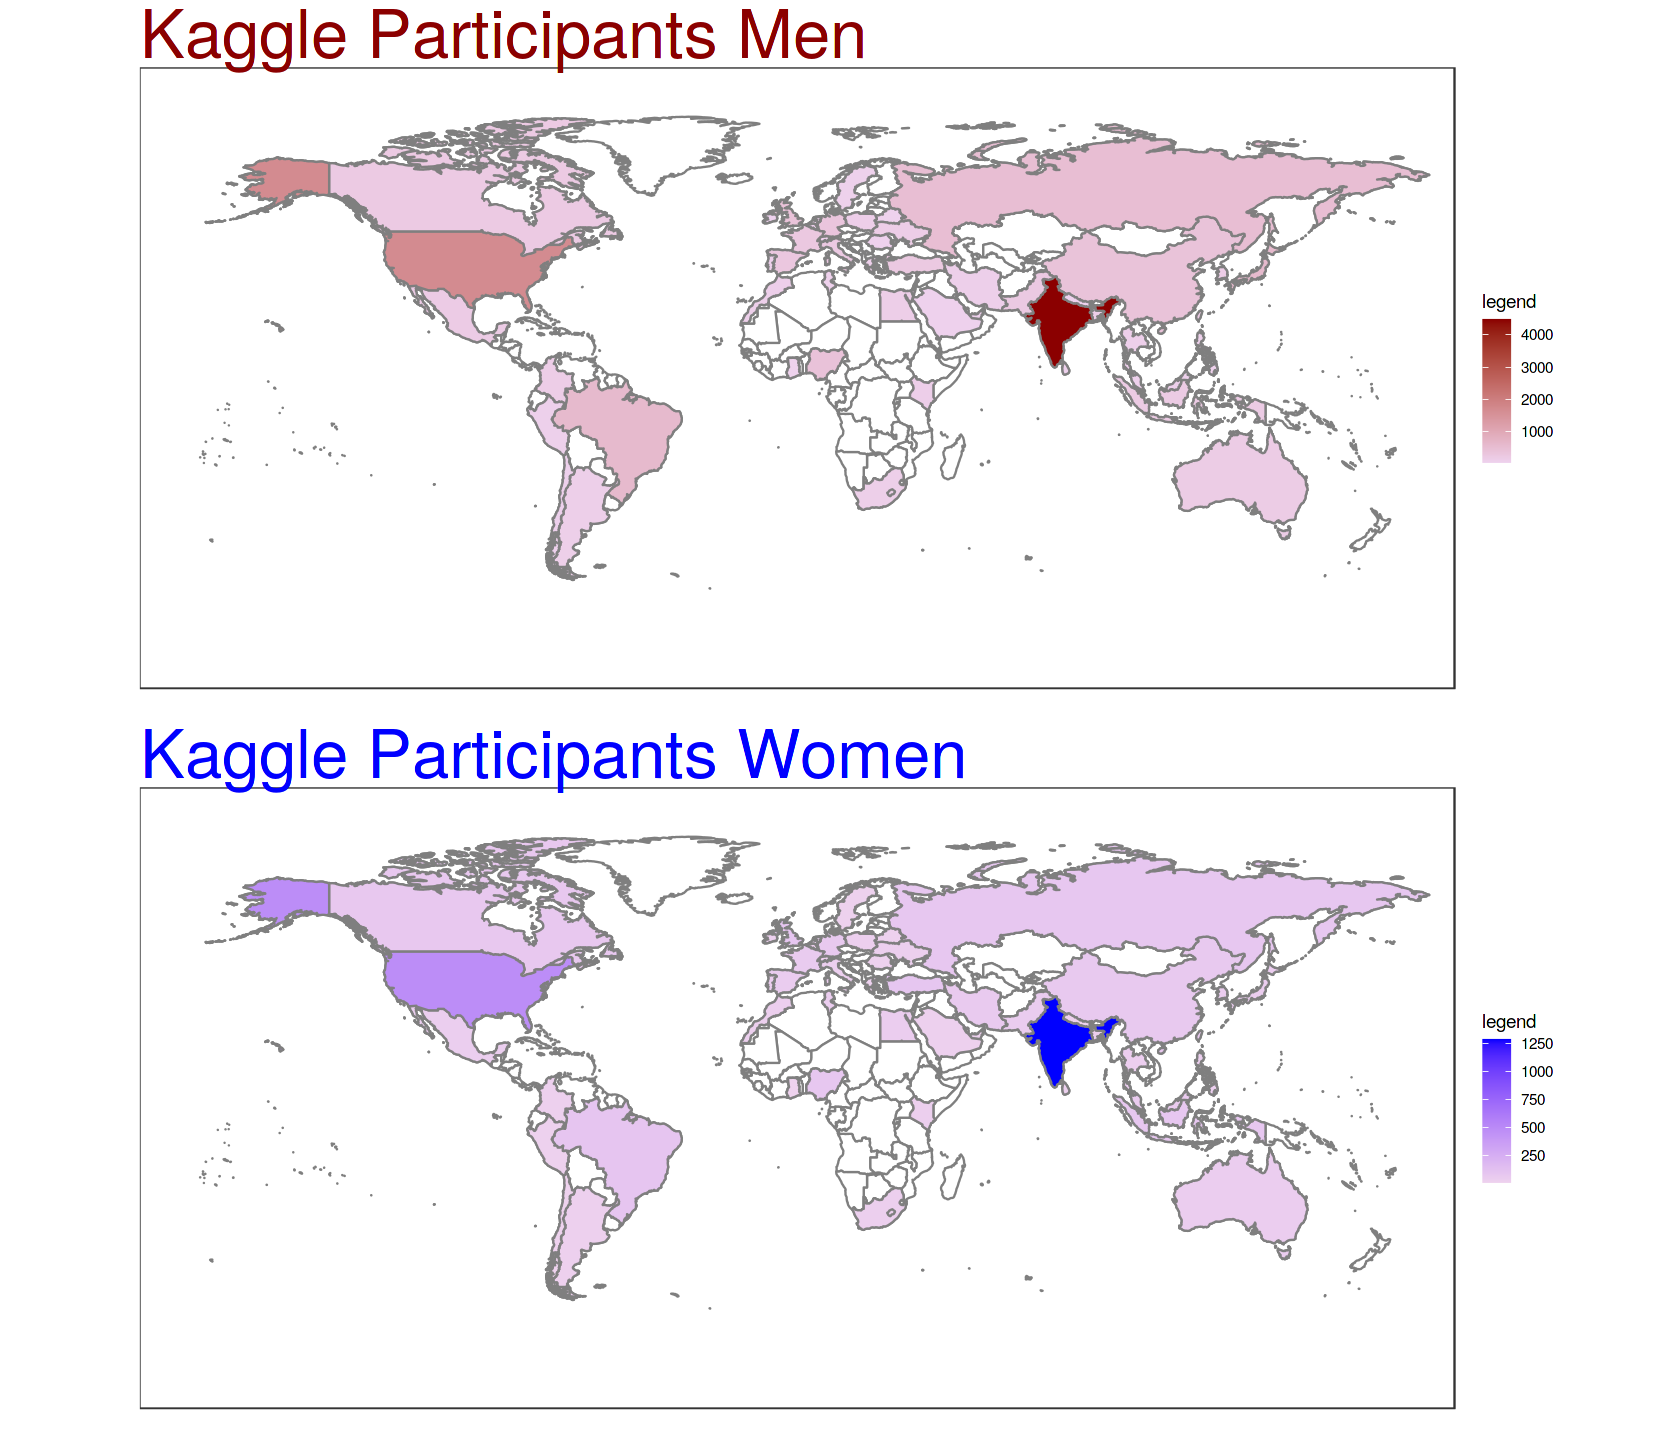

In [23]:
#Mapping the countries
options(repr.plot.width = 20, repr.plot.height = 12)
country.map <- country
names(country.map)<- c("region","gender", "freq")
country.map_m <- country.map %>% filter(gender=="Man")
country.map_f <- country.map %>% filter(gender=="Woman")
WorldData <- map_data('world') %>% filter(region != "Antarctica") %>% fortify

options(repr.plot.width = 14, repr.plot.height = 12)

map_man <- ggplot() +
  geom_map(data = WorldData, map = WorldData,
           aes(x = long, y = lat, group = group, map_id=region),
 fill = "white", colour = "#7f7f7f", size=0.5) + 
  geom_map(data = country.map_m, map=WorldData,
           aes(fill=freq, map_id=region),
           colour="#7f7f7f", size=0.5) +
  coord_map("rectangular", lat0=0, xlim=c(-180,180), ylim=c(-80, 90)) +
  scale_fill_continuous(low="thistle2", high="darkred", guide="colorbar") +
  scale_y_continuous(breaks=c()) +
  scale_x_continuous(breaks=c()) +
  labs(fill="legend", title="Kaggle Participants Men", x="", y="") +
  
  #facet_wrap( ~gender) +
  theme_bw()+
  theme(plot.title = element_text(size = 40, color = 'darkred', family = 'Times new Roman'))

map_woman <- ggplot() +
  geom_map(data = WorldData, map = WorldData,
           aes(x = long, y = lat, group = group, map_id=region),
           fill = "white", colour = "#7f7f7f", size=0.5) + 
  geom_map(data = country.map_f, map=WorldData,
           aes(fill=freq, map_id=region),
           colour="#7f7f7f", size=0.5) +
  coord_map("rectangular", lat0=0, xlim=c(-180,180), ylim=c(-80, 90)) +
  scale_fill_continuous(low="thistle2", high="blue", guide="colorbar") +
  scale_y_continuous(breaks=c()) +
  scale_x_continuous(breaks=c()) +
  labs(fill="legend", title="Kaggle Participants Women", x="", y="") +
  
  #facet_wrap( ~gender) +
  theme_bw()+
  theme(plot.title = element_text(size = 40, color = 'blue', family = 'Times new Roman'))

ggarrange(map_man, map_woman,ncol = 1, nrow = 2)

<div style="text-align: justify;
       font-size:20px">
The ratio of men to women participants remains almost constant throughout education level. In some professions such as software engieer, machine learning engineer, product/project manager and DBA/data base engineer, women are less than 25%.
</div>

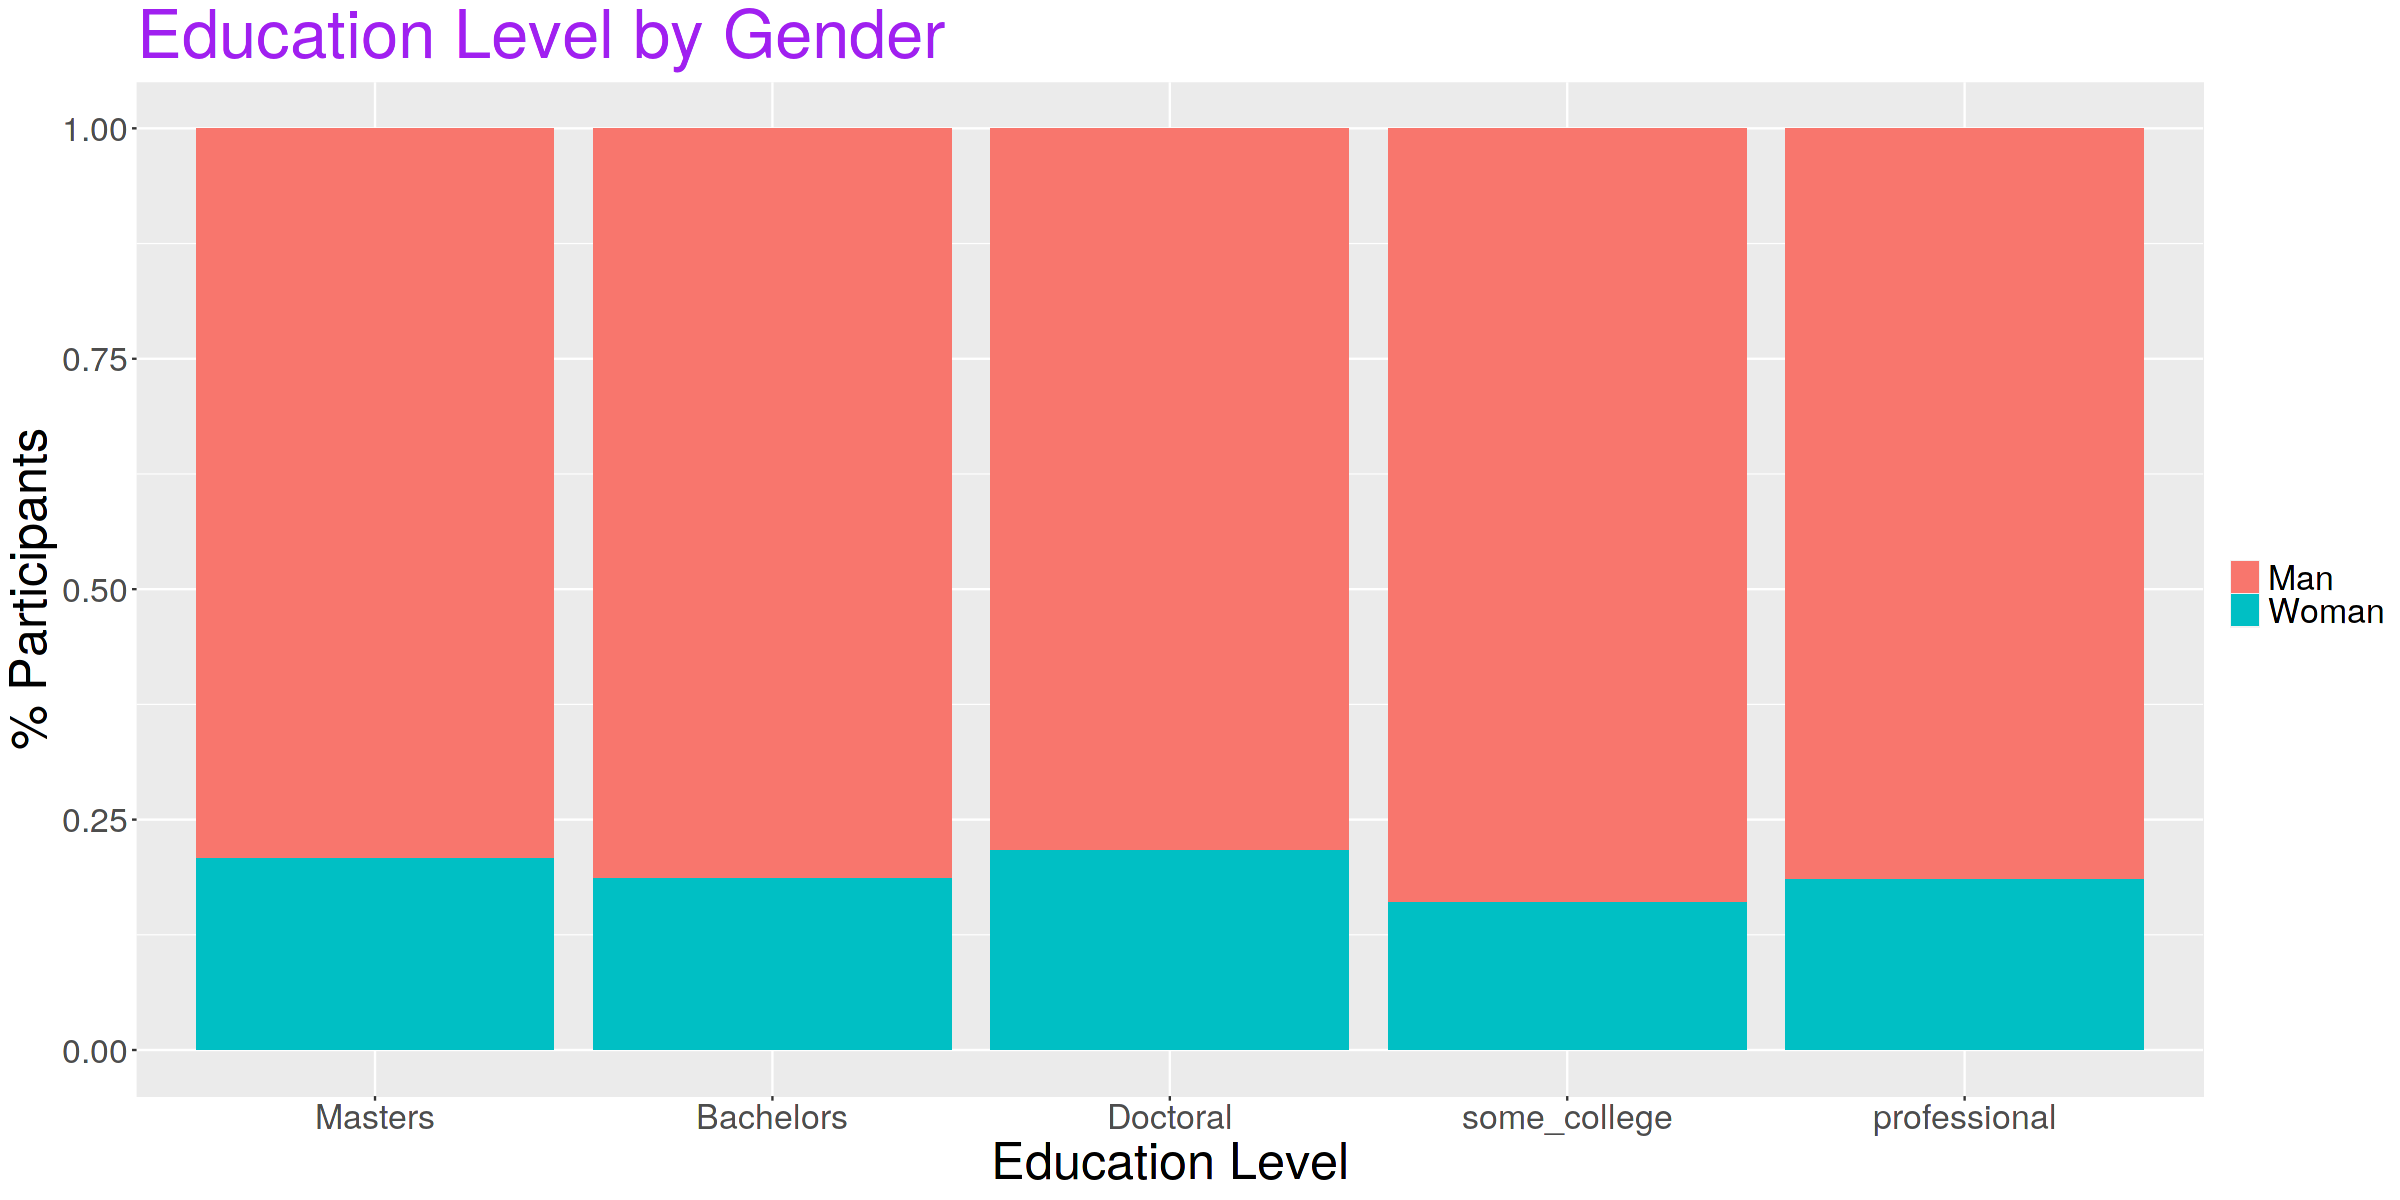

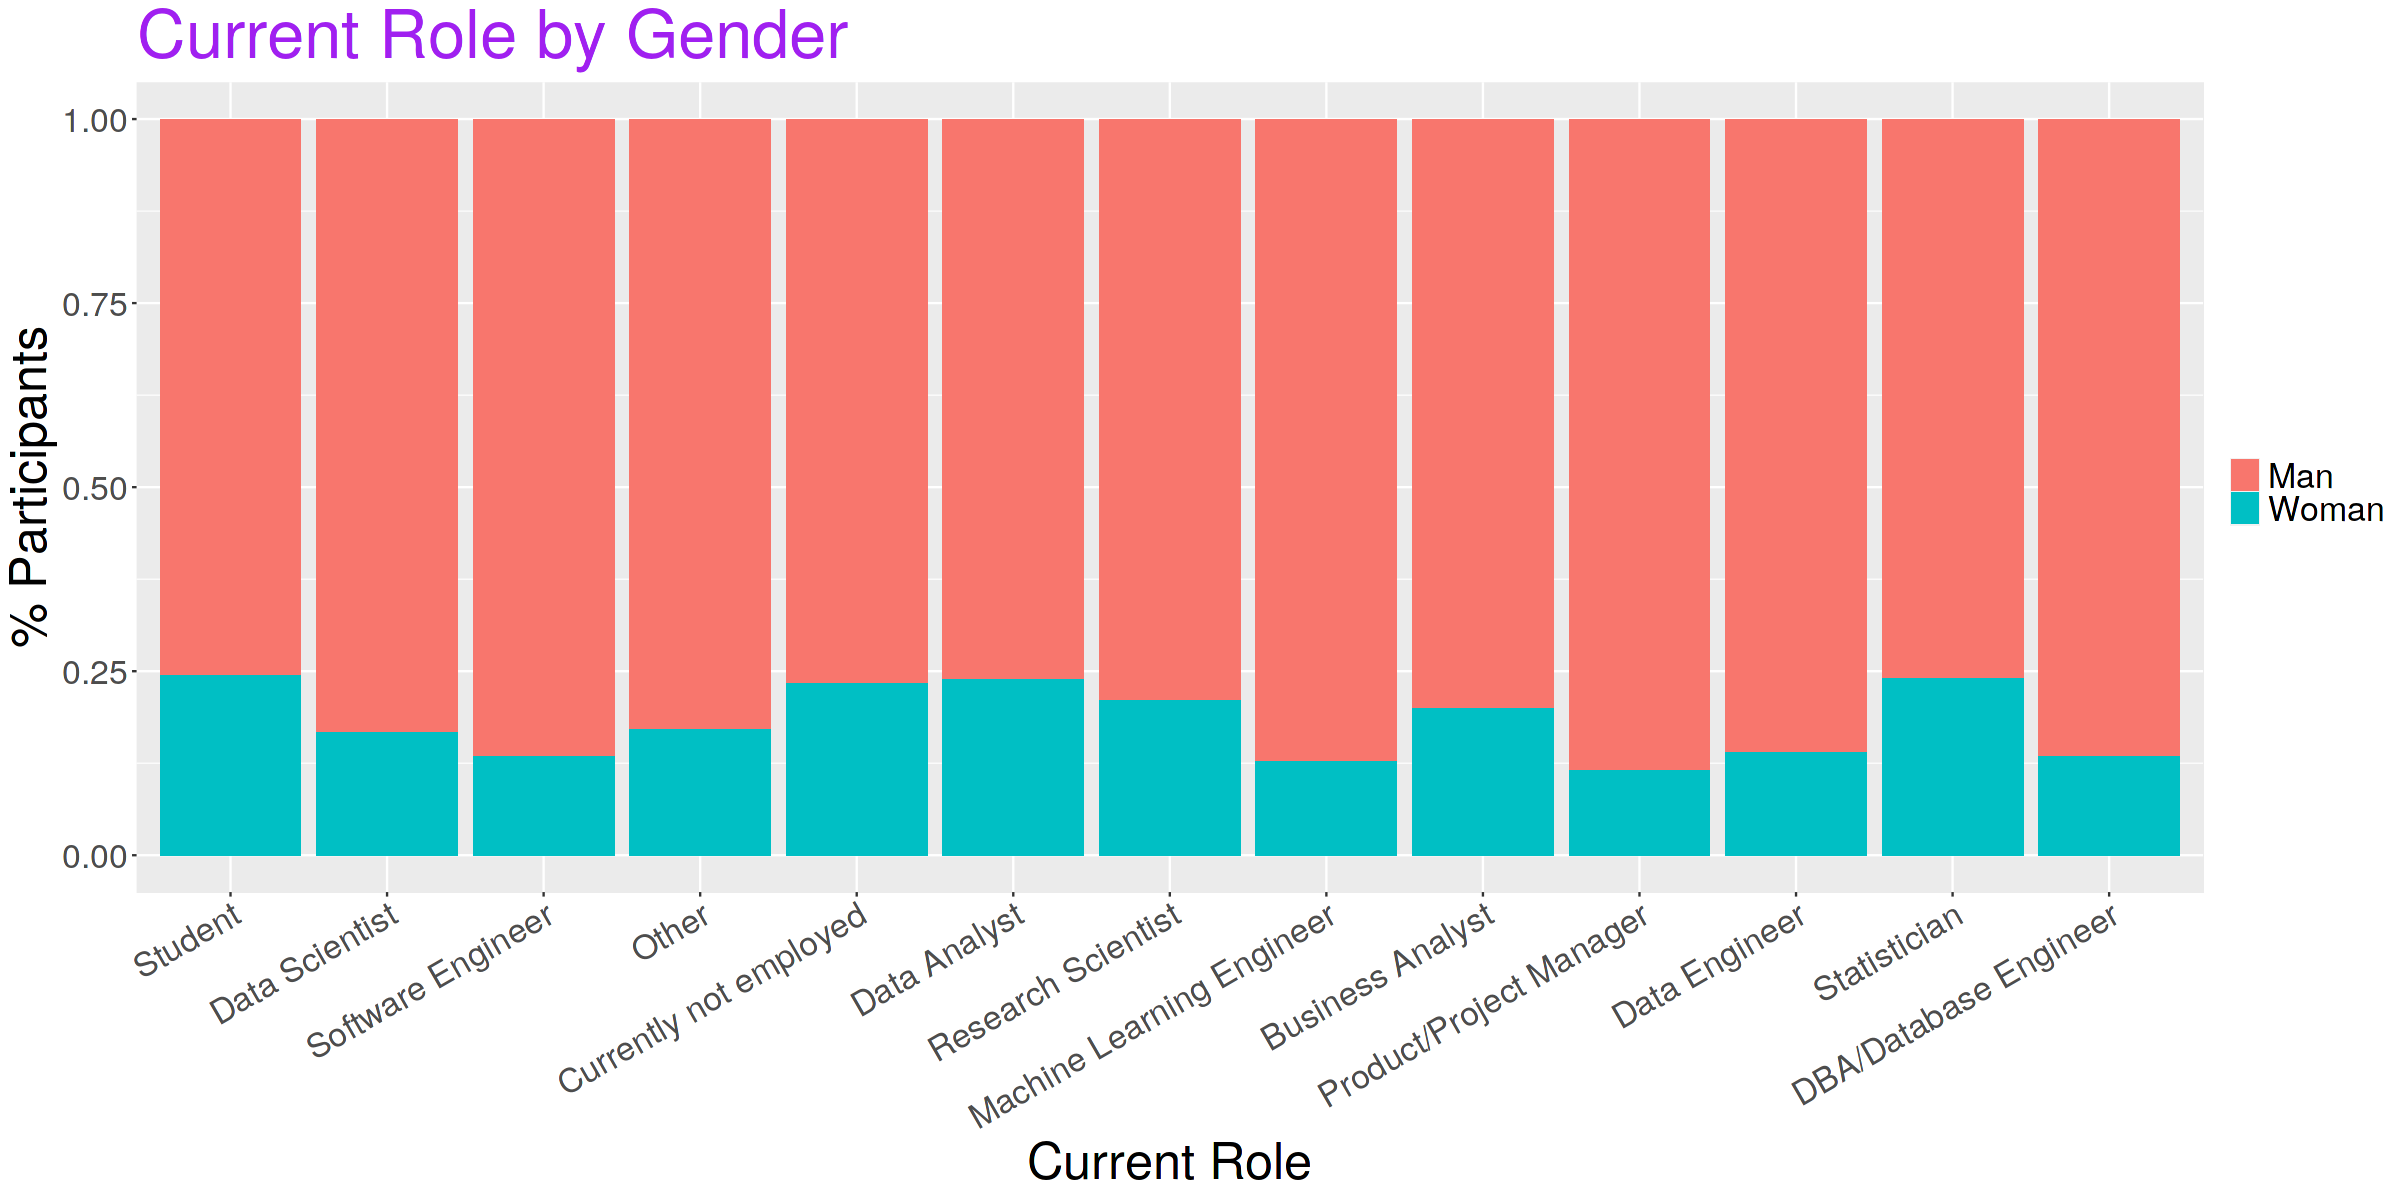

In [24]:
#Gender by Education level
####################################
#Participants by country
####################################
options(repr.plot.width = 20, repr.plot.height = 10)

#Normalized plot
gender_by_edu<- (dat2
                 %>% group_by(highest.edu, gender)
                 %>% summarize(participants = n(),.groups = 'drop')
                 %>% filter(gender %in% c("Man", "Woman")) 
                %>% filter(!highest.edu == "NoAnswer"))
edu<- gender_by_edu%>% group_by(highest.edu)%>% summarise(total = sum(participants),.groups = 'drop')
gender_by_edu<- gender_by_edu%>% left_join(., edu, by="highest.edu")%>% mutate(percent = participants/total)

gender_by_role<- (dat2
                 %>% group_by(gender, current.role)
                 %>% summarize(participants = n(),.groups = 'drop')
                 %>% filter(gender %in% c("Man", "Woman")))
role<- gender_by_role%>% group_by(current.role)%>% summarise(total = sum(participants),.groups = 'drop')

gender_by_role<- (gender_by_role%>% left_join(., role, by="current.role")%>% mutate(percent = participants/total)
                %>% filter(!current.role==""))



#Stacked bar with two panel
p1<- ggplot(gender_by_edu, aes(fill=gender, y=percent, x=reorder(highest.edu, -participants))) + 
     geom_bar(position="stack", stat="identity")+
     labs(x="Education Level",y="% Participants")+
     ggtitle("Education Level by Gender") +
     theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
     theme(legend.title = element_blank(),
         legend.text = element_text(size = 20)
          )

p2<-  ggplot(gender_by_role, aes(fill=gender, y=percent, x=reorder(current.role, -participants))) + 
      geom_bar(position="stack", stat="identity")+
      labs(x="Current Role",y="% Participants")+
      ggtitle("Current Role by Gender") +
        theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
      theme(legend.title = element_blank(),
           legend.text = element_text(size = 20),
      axis.text.x = element_text(angle = 30, hjust = 1))

#ggarrange(p1, p2,ncol = 1, nrow = 2)
p1
p2

In [25]:
#unique(gender_by_role$current.role)

<div style="text-align: justify;
       font-size:20px">
For both genders, kaggle participants are new in machine learning. About 67% of men and 76% of women have less than 2 years of experience. Only 3% of men and 1% of women have been implementing machine learning for more than 10 years.
</div>

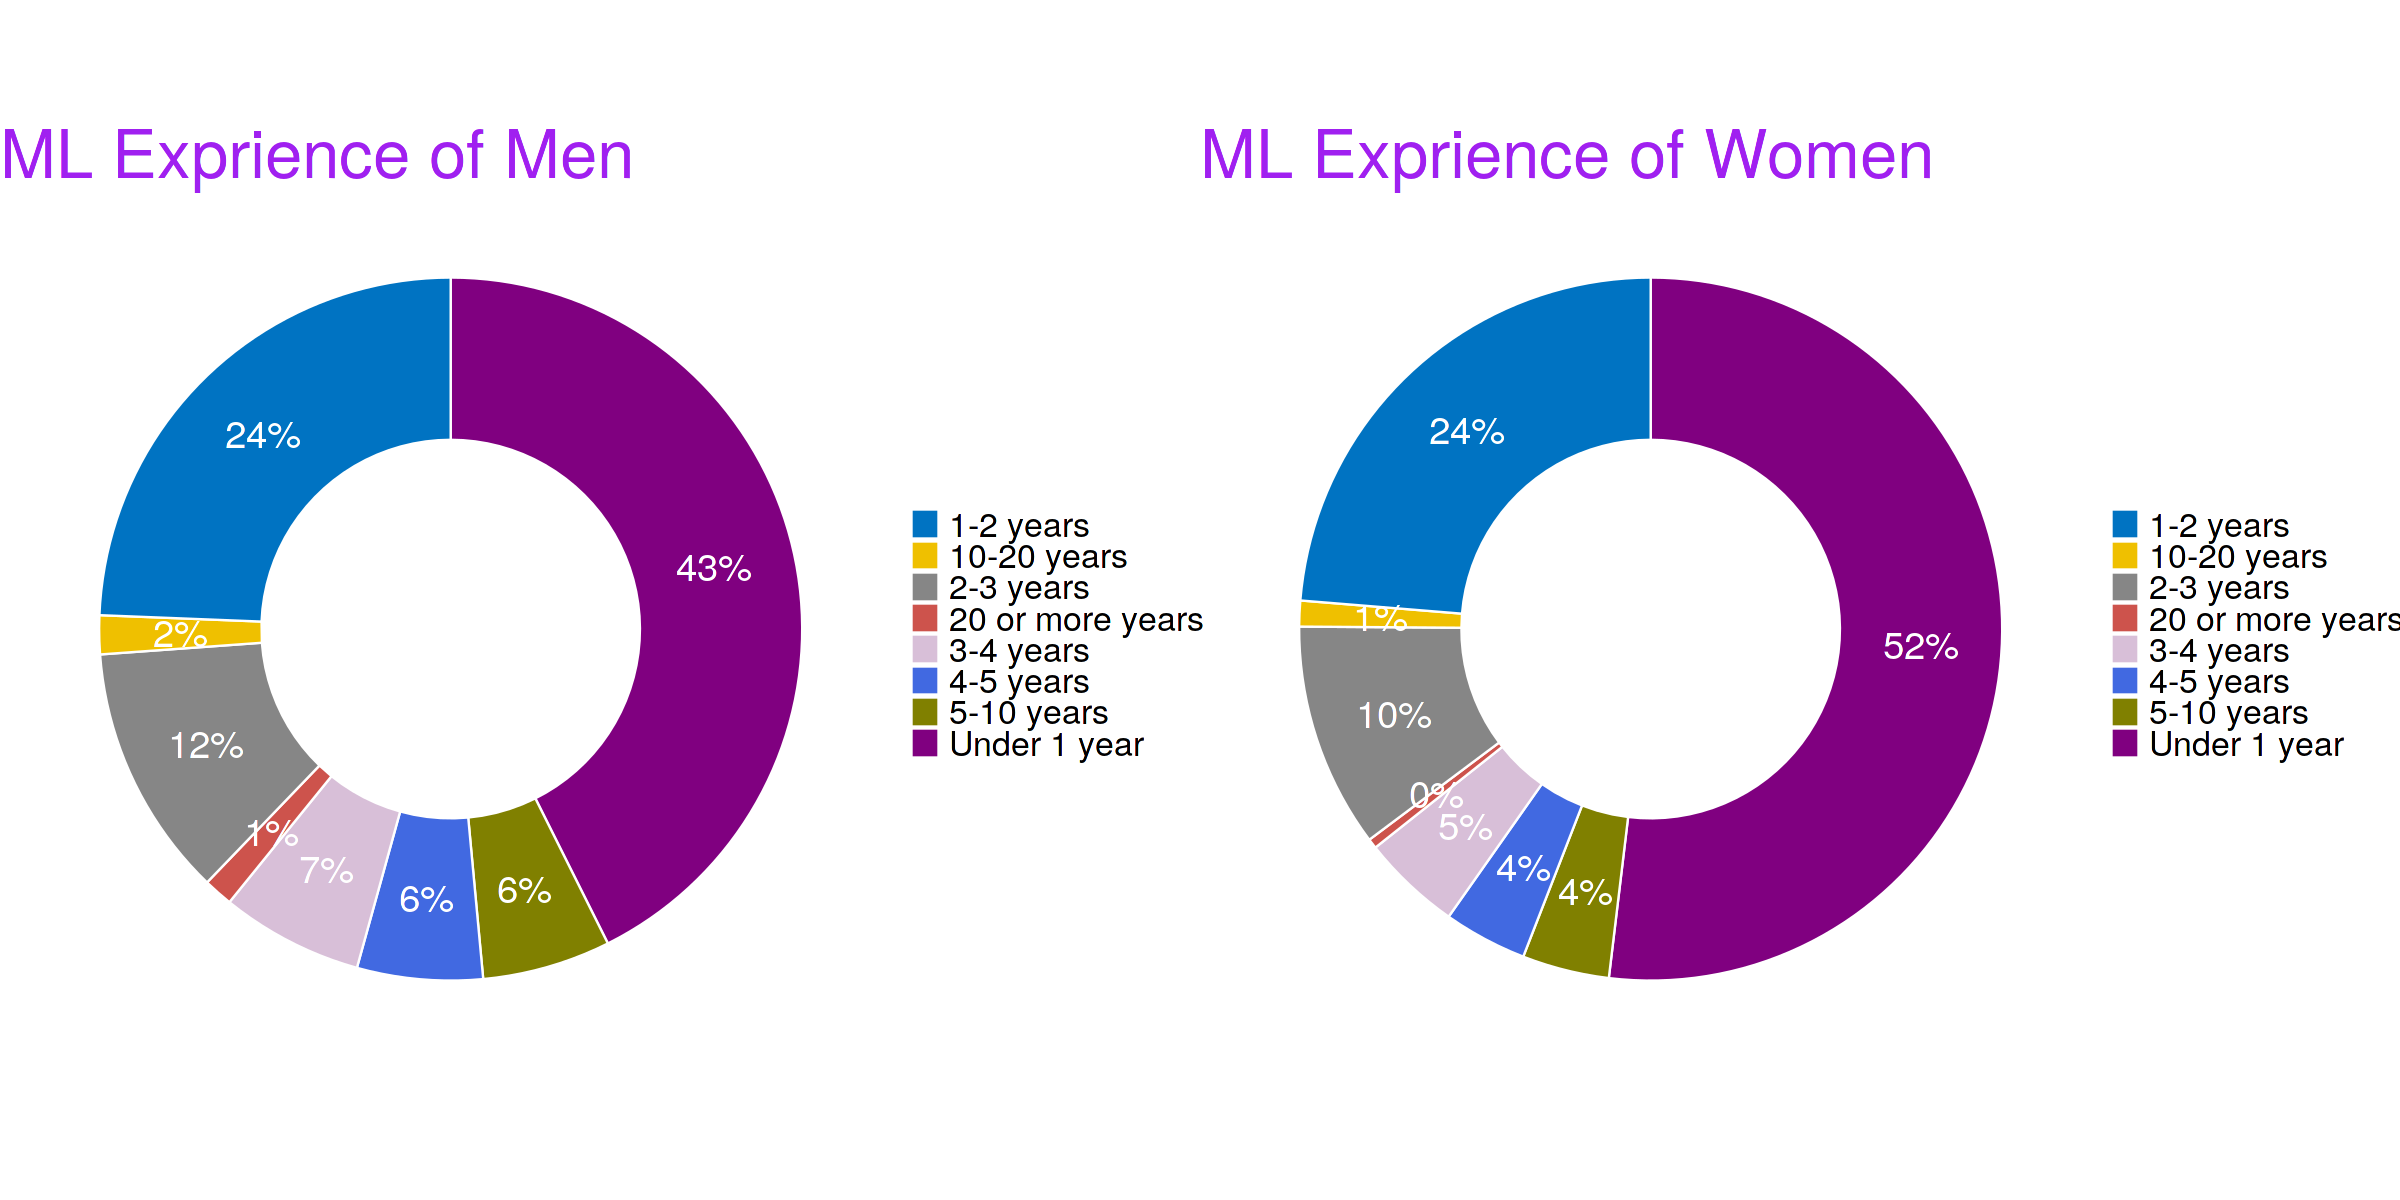

In [26]:
#Gender by ML experience
options(repr.plot.width = 20, repr.plot.height = 10)
ml_exp<- (dat2
          %>% group_by(Q15, gender)
          %>% summarize(participants = n(), .groups = 'drop')
          %>% filter(gender %in% c("Man", "Woman"))
          %>% filter(!Q15 %in% c("No Answer","No ML Experience"))
          %>% ungroup())
man_ml <- filter(ml_exp, gender == "Man")

#Donut chart
man_ml <- (man_ml 
           %>% mutate(ML_Exp = Q15, percent = participants/sum(man_ml$participants))
           %>% arrange(desc(Q15)) 
           %>% mutate(lab.ypos = cumsum(percent) - 0.5*percent))


mycols <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#D8BFD8","#4169E1",
            "#808000", "#800080", "#008080", "#9ACD32", "#DAA520", "#32CD32", "#9370DB")
mn<- ggplot(man_ml, aes(x = 2, y = percent, fill =ML_Exp)) +
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0)+
  geom_text(aes(y = lab.ypos, label = paste0(round(percent*100,0), "%")), size = 8,color = "white")+
  scale_fill_manual(values = mycols) +
  theme_void()+ xlim(0.5, 2.5)+
  ggtitle("ML Exprience of Men")+
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
      #legend.position = c(0.95, 0.70),
      legend.text = element_text(size = 20),)


woman_ml <- filter(ml_exp, gender != "Man")
woman_ml <- (woman_ml 
             %>% mutate(ML_Exp = Q15, percent = participants/sum(woman_ml$participants))
             %>% arrange(desc(Q15)) 
             %>% mutate(lab.ypos = cumsum(percent) - 0.5*percent))

mycols <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#D8BFD8","#4169E1",
            "#808000", "#800080", "#008080", "#9ACD32", "#DAA520", "#32CD32", "#9370DB")
wn<- ggplot(woman_ml, aes(x = 2, y = percent, fill =ML_Exp)) +
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0)+
  geom_text(aes(y = lab.ypos, label = paste0(round(percent*100,0), "%")), size = 8, color = "white")+
  scale_fill_manual(values = mycols) +
  theme_void()+ xlim(0.5, 2.5)+
  ggtitle("ML Exprience of Women")+
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
      #legend.position = c(0.95, 0.70),
      legend.text = element_text(size = 20))

ggarrange(mn, wn,ncol = 2, nrow = 1)

In [27]:
#ML Experience with Number of Programming Language
prog_by_LM_Exp<- (dat2
                   %>% mutate(prog_all = (Q7_Part_1.Python+Q7_Part_2.R+Q7_Part_3.SQL+Q7_Part_4.C+
                                   Q7_Part_5.C..+Q7_Part_6.Java+Q7_Part_7.Javascript+Q7_Part_8.Julia+
                                   Q7_Part_9.Swift+Q7_Part_10.Bash+Q7_Part_11.MATLAB+Q7_Part_12.None+Q7_OTHER.Other),
                              prog_1 = ifelse(prog_all == 1, 1, 0),
                              prog_2 = ifelse(prog_all == 2, 1, 0),
                              prog_3 = ifelse(prog_all == 3, 1, 0),
                              prog_4 = ifelse(prog_all == 4, 1, 0),
                              prog_5 = ifelse(prog_all > 4, 1, 0))
                   %>% group_by(Q15)
                   %>% summarize(prog_1 = sum(prog_1),
                                 prog_2 = sum(prog_2),
                                 prog_3 = sum(prog_3),
                                 prog_4 = sum(prog_4),
                                 prog_5 = sum(prog_5), .groups = 'drop')
                  
)



#  <span style='color:purple'>Women in Kaggle</span>

<div style="text-align: justify;
       font-size:20px">
 For most countries, more than 75% of women participants have a college degree. Majority of them have masters degree. 
 
</div>

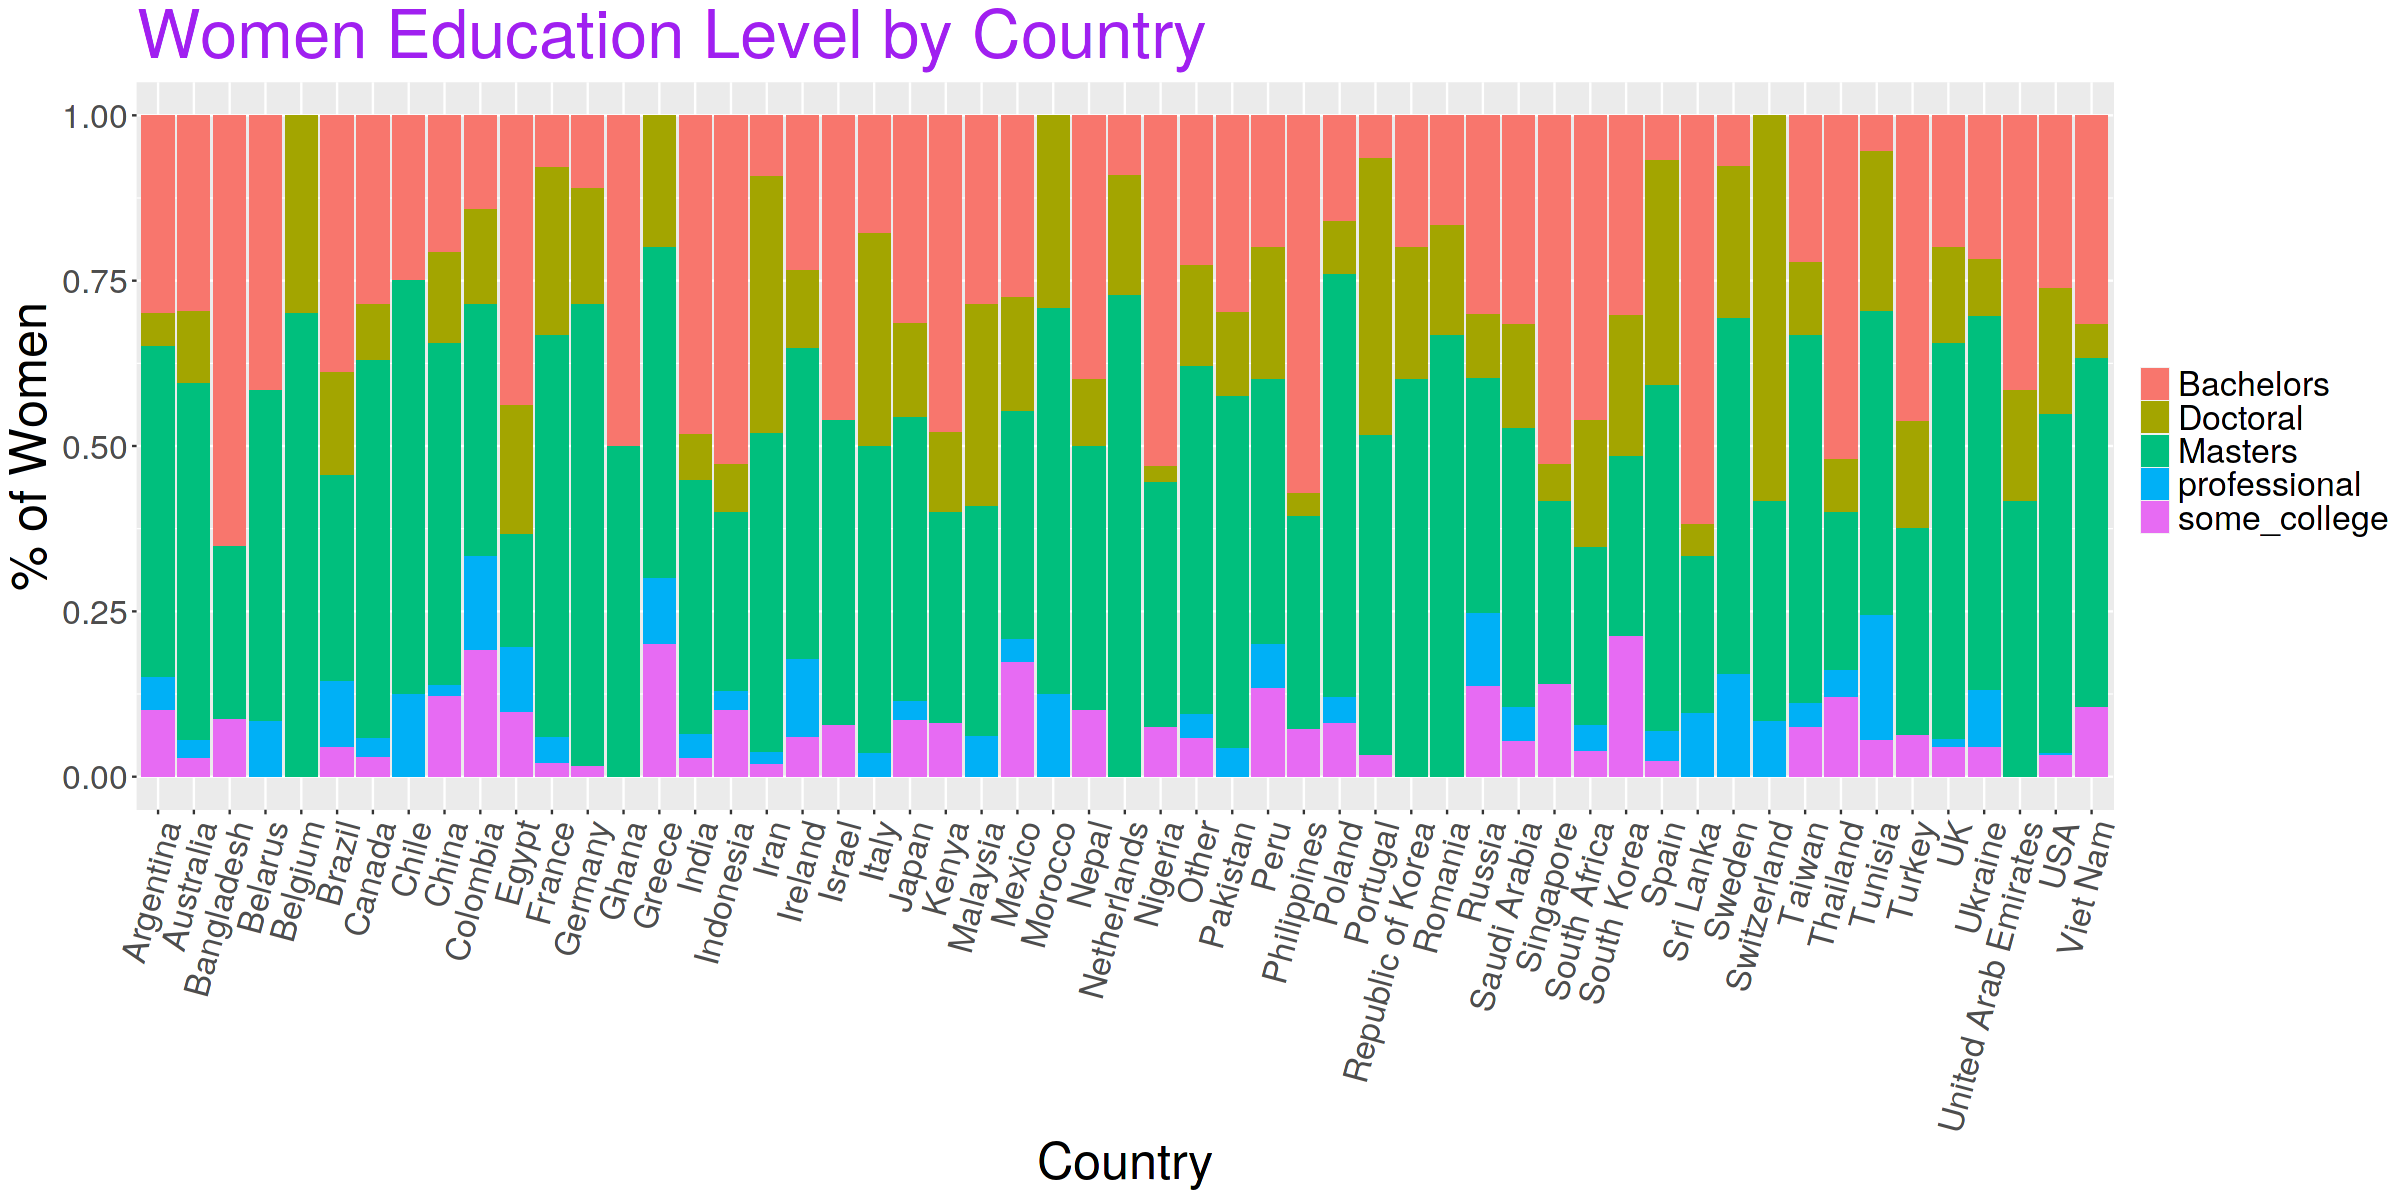

In [28]:
#Education by country

wn_edu_country<- (dat2
               %>% filter(gender == "Woman")
               %>% group_by(country, highest.edu)
               %>% filter(!highest.edu =="NoAnswer")
               %>% summarize(women_num = n(), .groups = 'drop')
               %>% ungroup()
               
)

wn_country <- wn_edu_country%>% group_by(country)%>% summarize(total_w = sum(women_num),.groups = 'drop')
wn_edu_country<- (wn_edu_country
                  %>% left_join(., wn_country, by="country")
                  %>% mutate(percent_w = women_num/total_w
                              ))

#Stacked BarPlot 
ggplot(wn_edu_country, aes(fill=highest.edu, y=percent_w, x=country)) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Country",y="% of Women")+
  ggtitle("Women Education Level by Country") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
        legend.text = element_text(size = 20),
        axis.text.x = element_text(angle = 75, hjust = 1))



<div style="text-align: justify;
       font-size:20px">
 The knowledge of multiple programming language is prevalent in all age group. The fraction of participants using 4 or 5 programming language is skewed higher towards younger generations. 
 
</div>

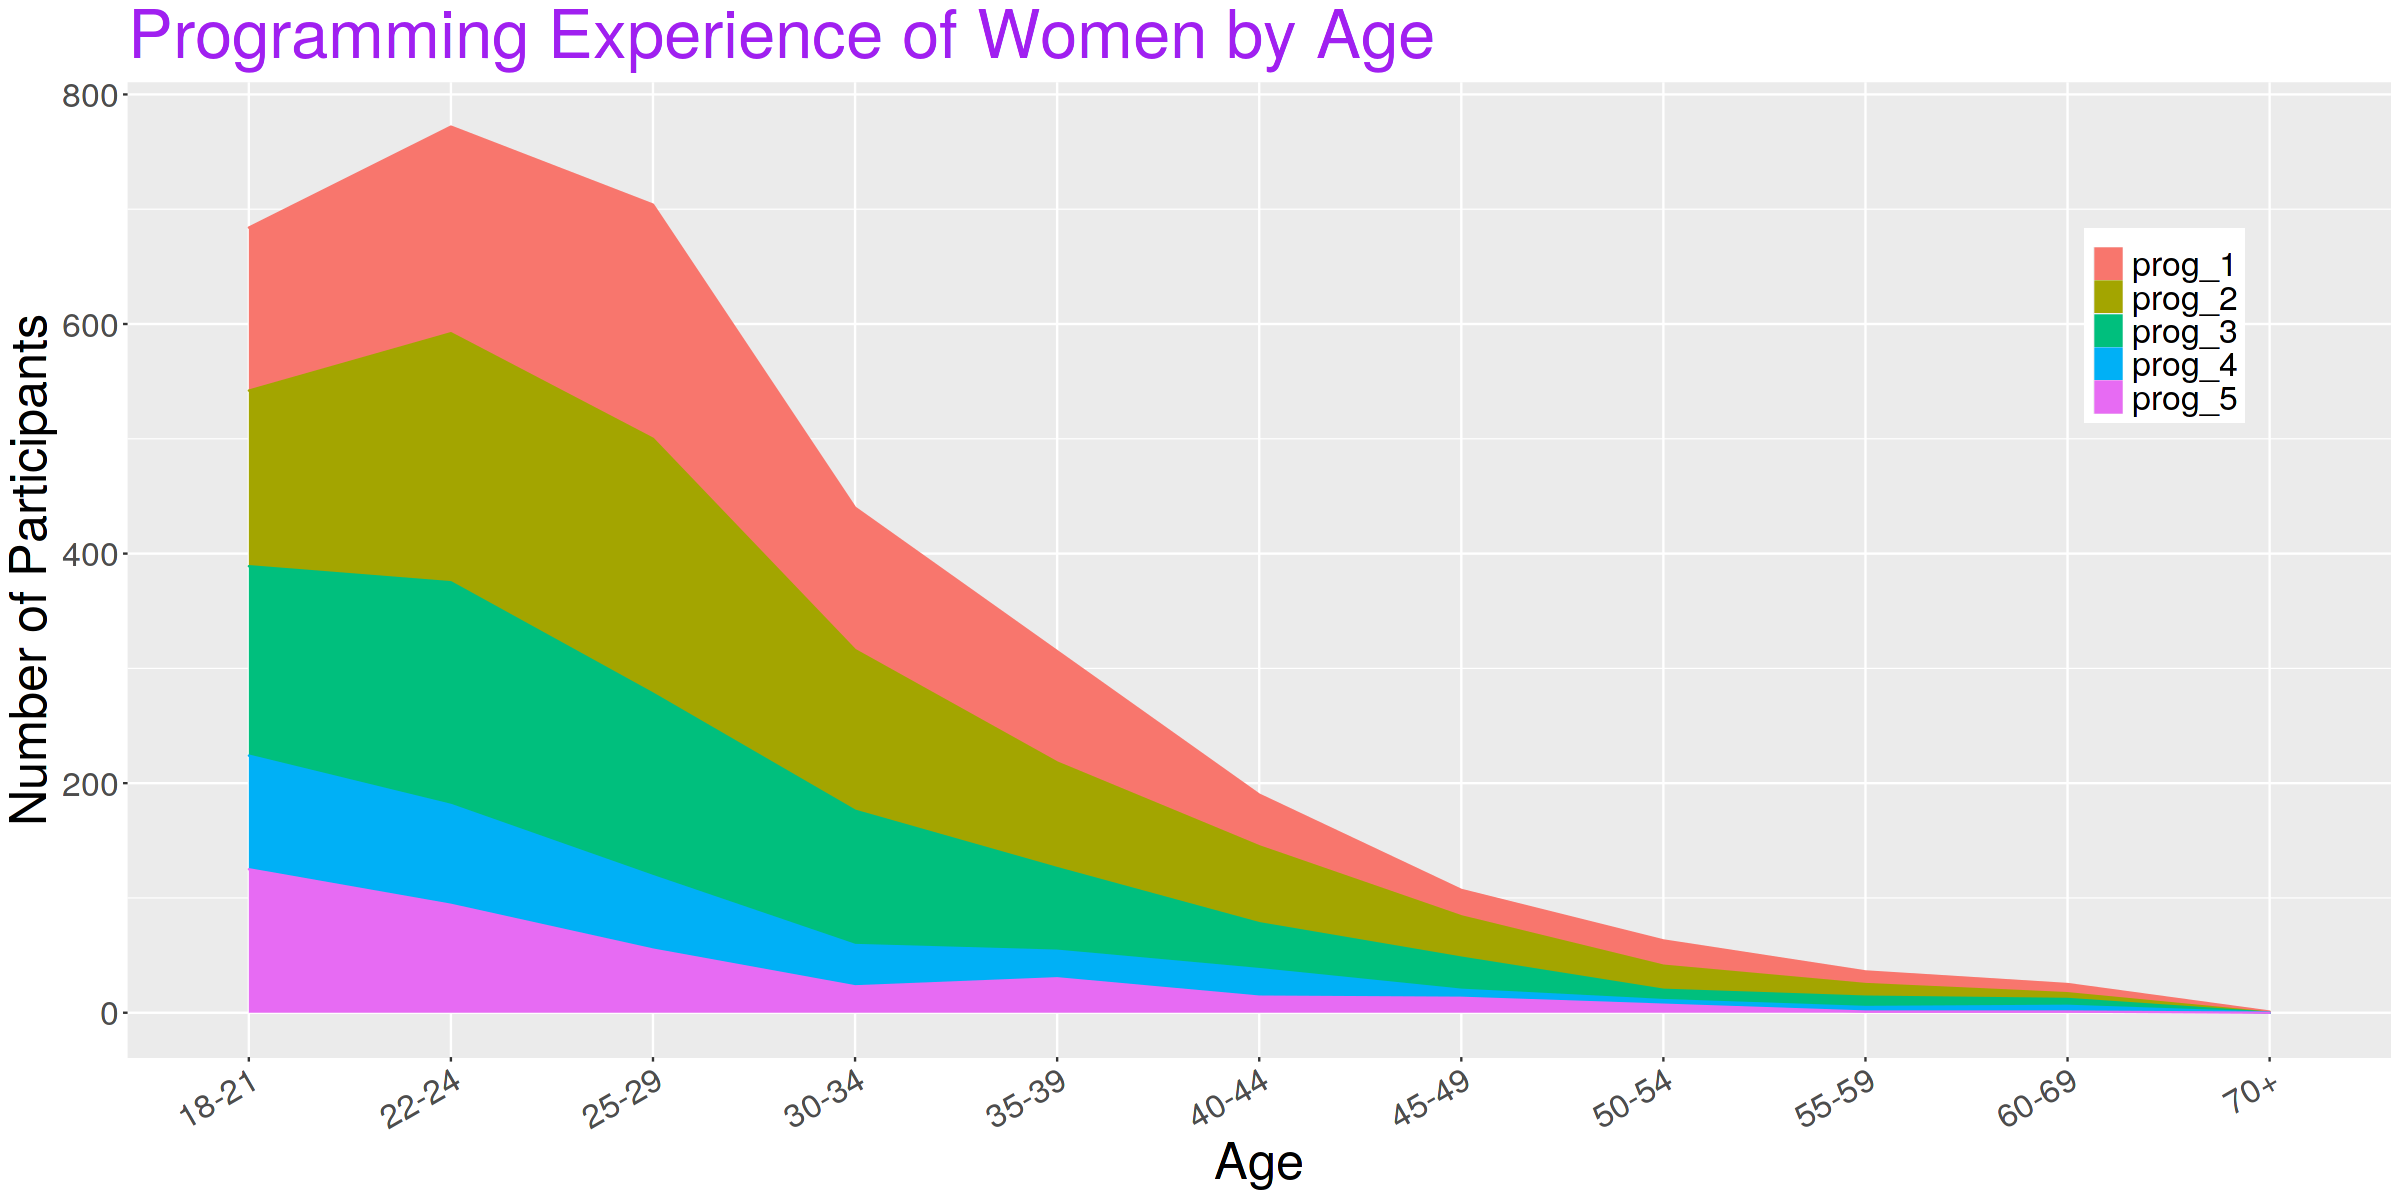

In [29]:
#Coding Experience by age group
wn_coding_age<- (dat2
                 %>% filter(gender == "Woman")
                  %>% mutate(prog_all = (Q7_Part_1.Python+Q7_Part_2.R+Q7_Part_3.SQL+Q7_Part_4.C+
                                   Q7_Part_5.C..+Q7_Part_6.Java+Q7_Part_7.Javascript+Q7_Part_8.Julia+
                                   Q7_Part_9.Swift+Q7_Part_10.Bash+Q7_Part_11.MATLAB+Q7_Part_12.None+Q7_OTHER.Other),
                             prog_1 = ifelse(prog_all == 1, 1, 0),
                             prog_2 = ifelse(prog_all == 2, 1, 0),
                             prog_3 = ifelse(prog_all == 3, 1, 0),
                             prog_4 = ifelse(prog_all == 4, 1, 0),
                             prog_5 = ifelse(prog_all > 4, 1, 0))
                  %>% group_by(Age)
                  %>% summarize(prog_1 = sum(prog_1),
                                prog_2 = sum(prog_2),
                                prog_3 = sum(prog_3),
                                prog_4 = sum(prog_4),
                                prog_5 = sum(prog_5),
                                .groups = 'drop')
                 #%>% filter(Q15 != "")
)


#Area Plot 
wn_coding_age<- melt(wn_coding_age, id = c("Age"))
wn_coding_age %>% ggplot(aes(x= Age, y=value)) + 
  geom_area(aes(colour = variable, group=variable, fill = variable))+
  labs(x="Age",y="Number of Participants")+
  ggtitle("Programming Experience of Women by Age") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  
  theme(legend.title = element_blank(),
    legend.position = c(0.90, 0.75),
    legend.text = element_text(size = 20),
    axis.text.x = element_text(angle = 30, hjust = 1))
 

<div style="text-align: justify;
       font-size:20px">
 In  all professions, most women have less than 3 years of machine learning experience. Significant fraction of women professionals with more than 3 years of machine learning experience are Data Scientist, Research Scientist and Machine Learning engineer.
 
</div>

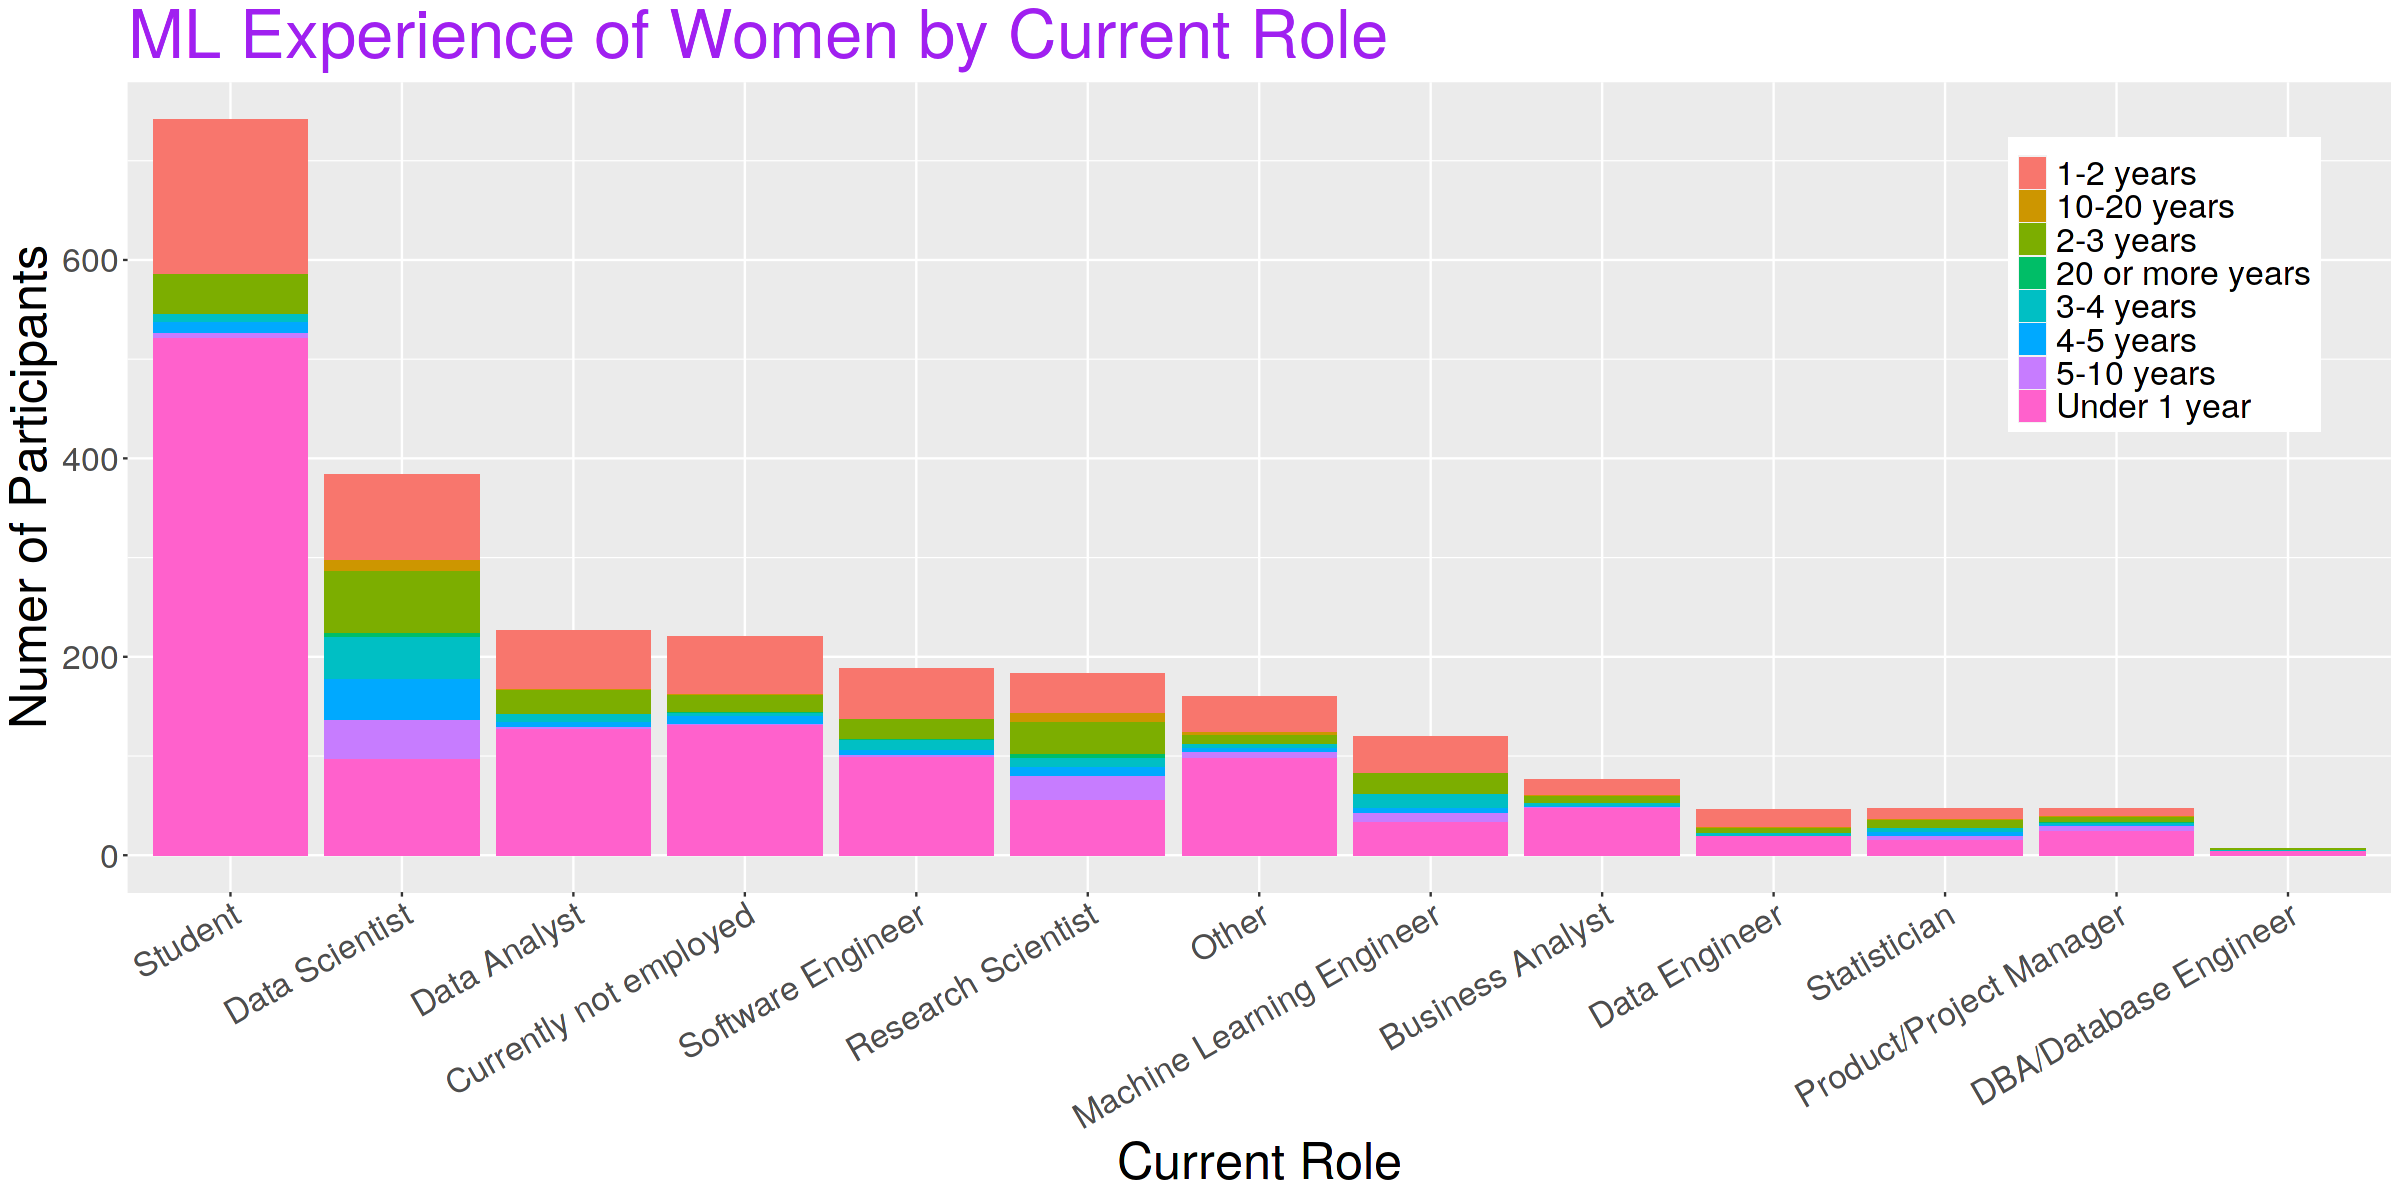

In [30]:
#Current role and Machine Learning Experience
wn_ml_exp <- (dat2
              %>% filter(gender == "Woman")
              %>% group_by(Q15, current.role)
              %>% summarize(participants = n(),.groups = 'drop')
              %>% mutate(Q15 = ifelse(Q15 == "", "No Answer",
                                      ifelse(Q15 =="I do not use machine learning methods", "No ML Experience", as.character(Q15))),
                         current.role = ifelse(current.role == "", "NoAnswer", as.character(current.role)))
              %>% ungroup()
              %>% filter(!Q15 %in% c("No Answer","No ML Experience"))
              %>% rename(ML_Exp= Q15))


#Plot
ggplot(wn_ml_exp, aes(fill=ML_Exp, y=participants, x=reorder(current.role, -participants))) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Current Role",y="Numer of Participants")+
  ggtitle("ML Experience of Women by Current Role") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
    legend.position = c(0.90, 0.75),
    legend.text = element_text(size = 20),
    axis.text.x = element_text(angle = 30, hjust = 1))



# <span style='color:purple'> Inside the United States </span>

<div style="text-align: justify;
       font-size:20px">
For both gender in  all professions, education level is mixed with majority of participants have masters degree except research scientist where there are majority with doctorate degree. Data analyst, Business analyst and DBA/Data base engineer have least fractions of participants with doctorate degree for both gender. 
    <br>
    <br>
Notably, significant fraction of men in Software Enigeer and small fractions in Data Scientist, Data Analyst, Business Analyst, Product/Project manager and Machine Learning Engineers are working without a college degree in the United States. 
However all women professions except students have a college degree.
</div>

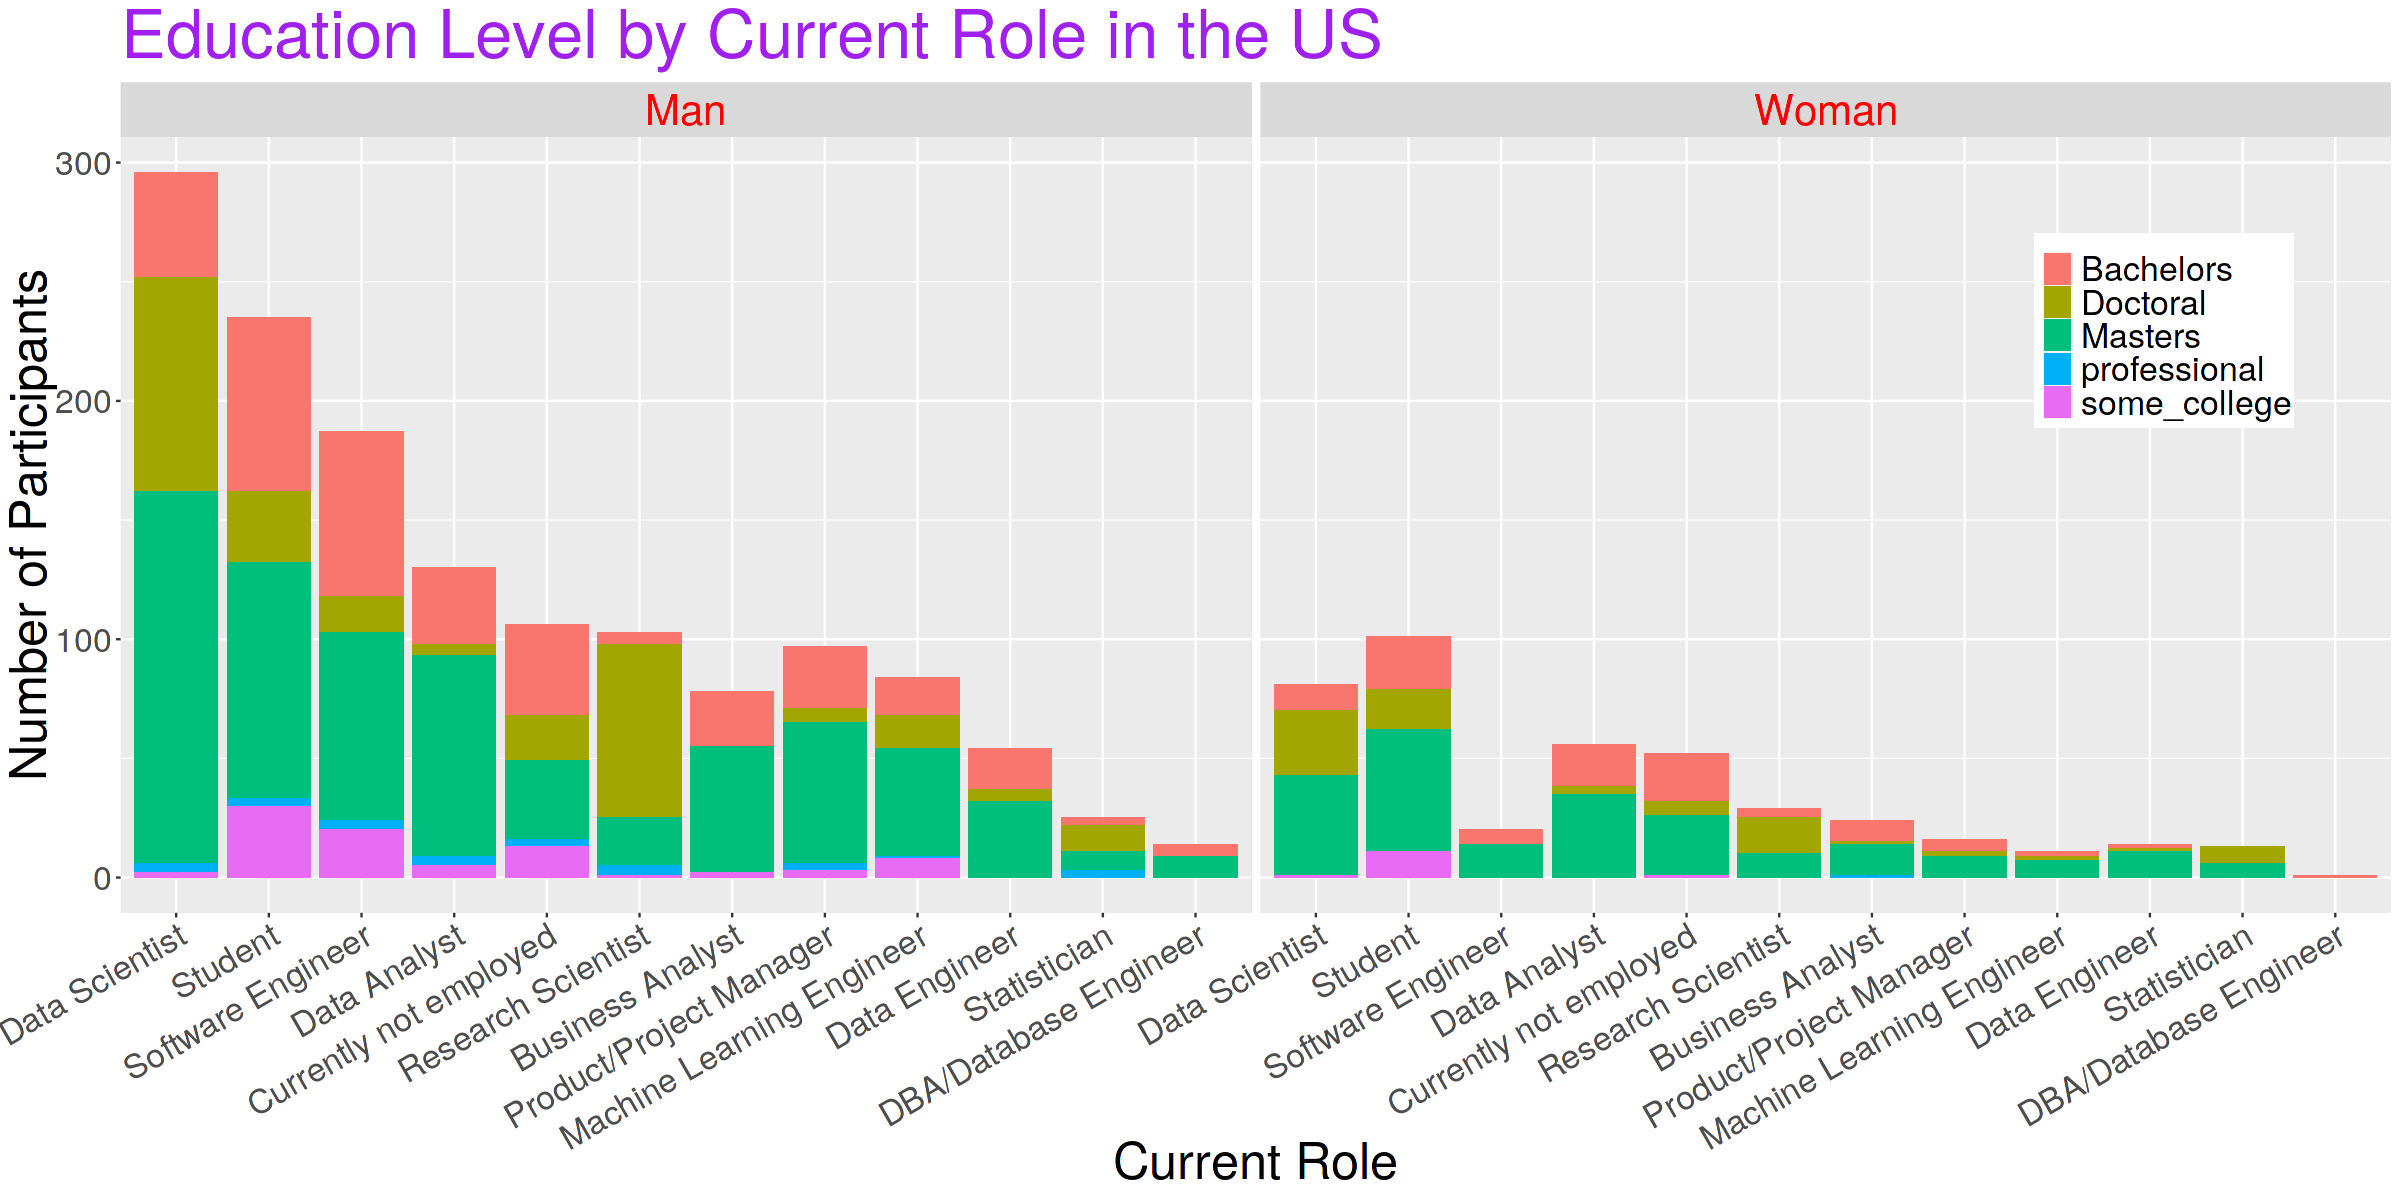

In [31]:
# Education and current role
us_edu <- (dat2
          %>% filter(country == "USA")
           %>% filter(gender %in% c("Man","Woman"))
          %>% group_by(current.role,gender, highest.edu)
          %>% summarize(num = n(), .groups = 'drop')
          %>% ungroup()
          %>% filter(current.role != "" & current.role != "Other")
           %>% filter(!highest.edu =="NoAnswer")
         )

#Bar chart
ggplot(us_edu, aes(fill=highest.edu, y=num, x=reorder(current.role, -num))) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Current Role",y="Number of Participants")+
  ggtitle("Education Level by Current Role in the US") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
        legend.position = c(0.90, 0.75),
        legend.text = element_text(size = 20),
        axis.text.x = element_text(angle = 30, hjust = 1))+facet_wrap(~gender)+
theme(strip.text.x = element_text(size = 25, colour = "red"))

<div style="text-align: justify;
       font-size:20px">
Data scientists are majority in  age group of 30-34 and 35-39 for both men, 30-34 and 40-44 for women. 
</div>

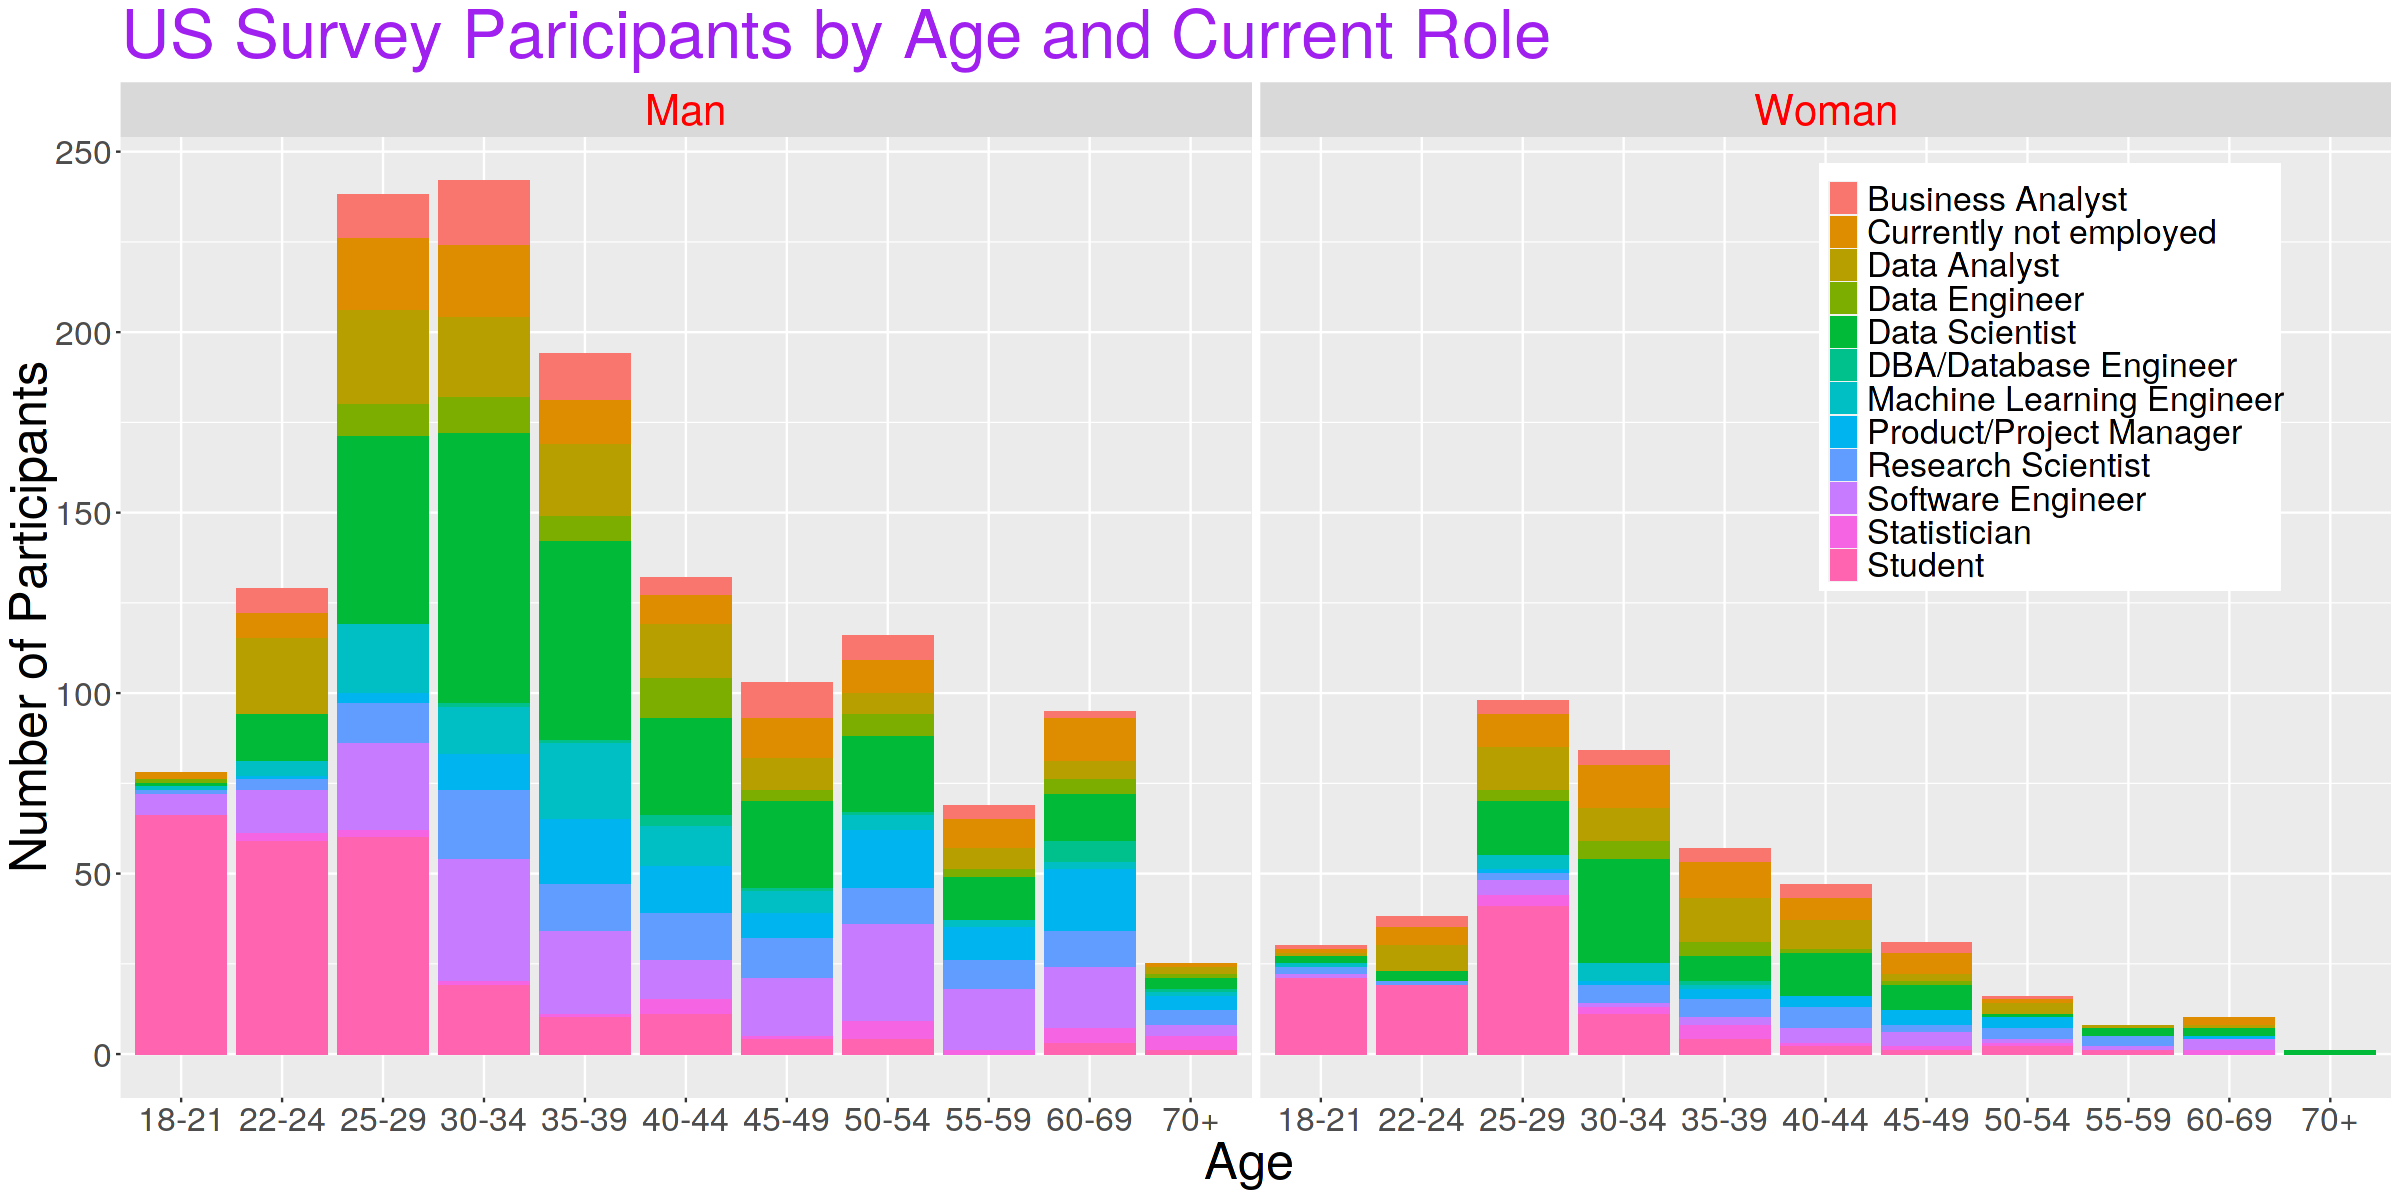

In [32]:
#US Kaggle survey participanst by Age and current role
us_age_role <- (dat2
          %>% filter(country == "USA") 
          %>% filter(gender %in% c("Man","Woman"))
          %>% group_by(Age, gender, current.role)
          %>% summarize(num = n(), .groups = 'drop')
          %>% filter(current.role != "" & current.role != "Other")
          
)

#Bar chart
ggplot(us_age_role, aes(fill=current.role, y=num, x=Age)) + 
  geom_bar(position="stack", stat="identity")+
  labs(x="Age ",y="Number of Participants")+
  ggtitle("US Survey Paricipants by Age and Current Role") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
      legend.position = c(0.85, 0.75),
      legend.text = element_text(size = 20))+
  facet_wrap(~gender)+
theme(strip.text.x = element_text(size = 25, colour = "red"))

<div style="text-align: justify;
       font-size:20px">
For men, fraction of populations with the knowlege of 4 or 5 programming languages is pretty much constant in all ML experience level. However, in the case of women 2-3 years of ML experience level have higher fractions of populations with the knowledge of 4 or 5 programming languages, and very small or negligible for most other experience levels.    
</div>

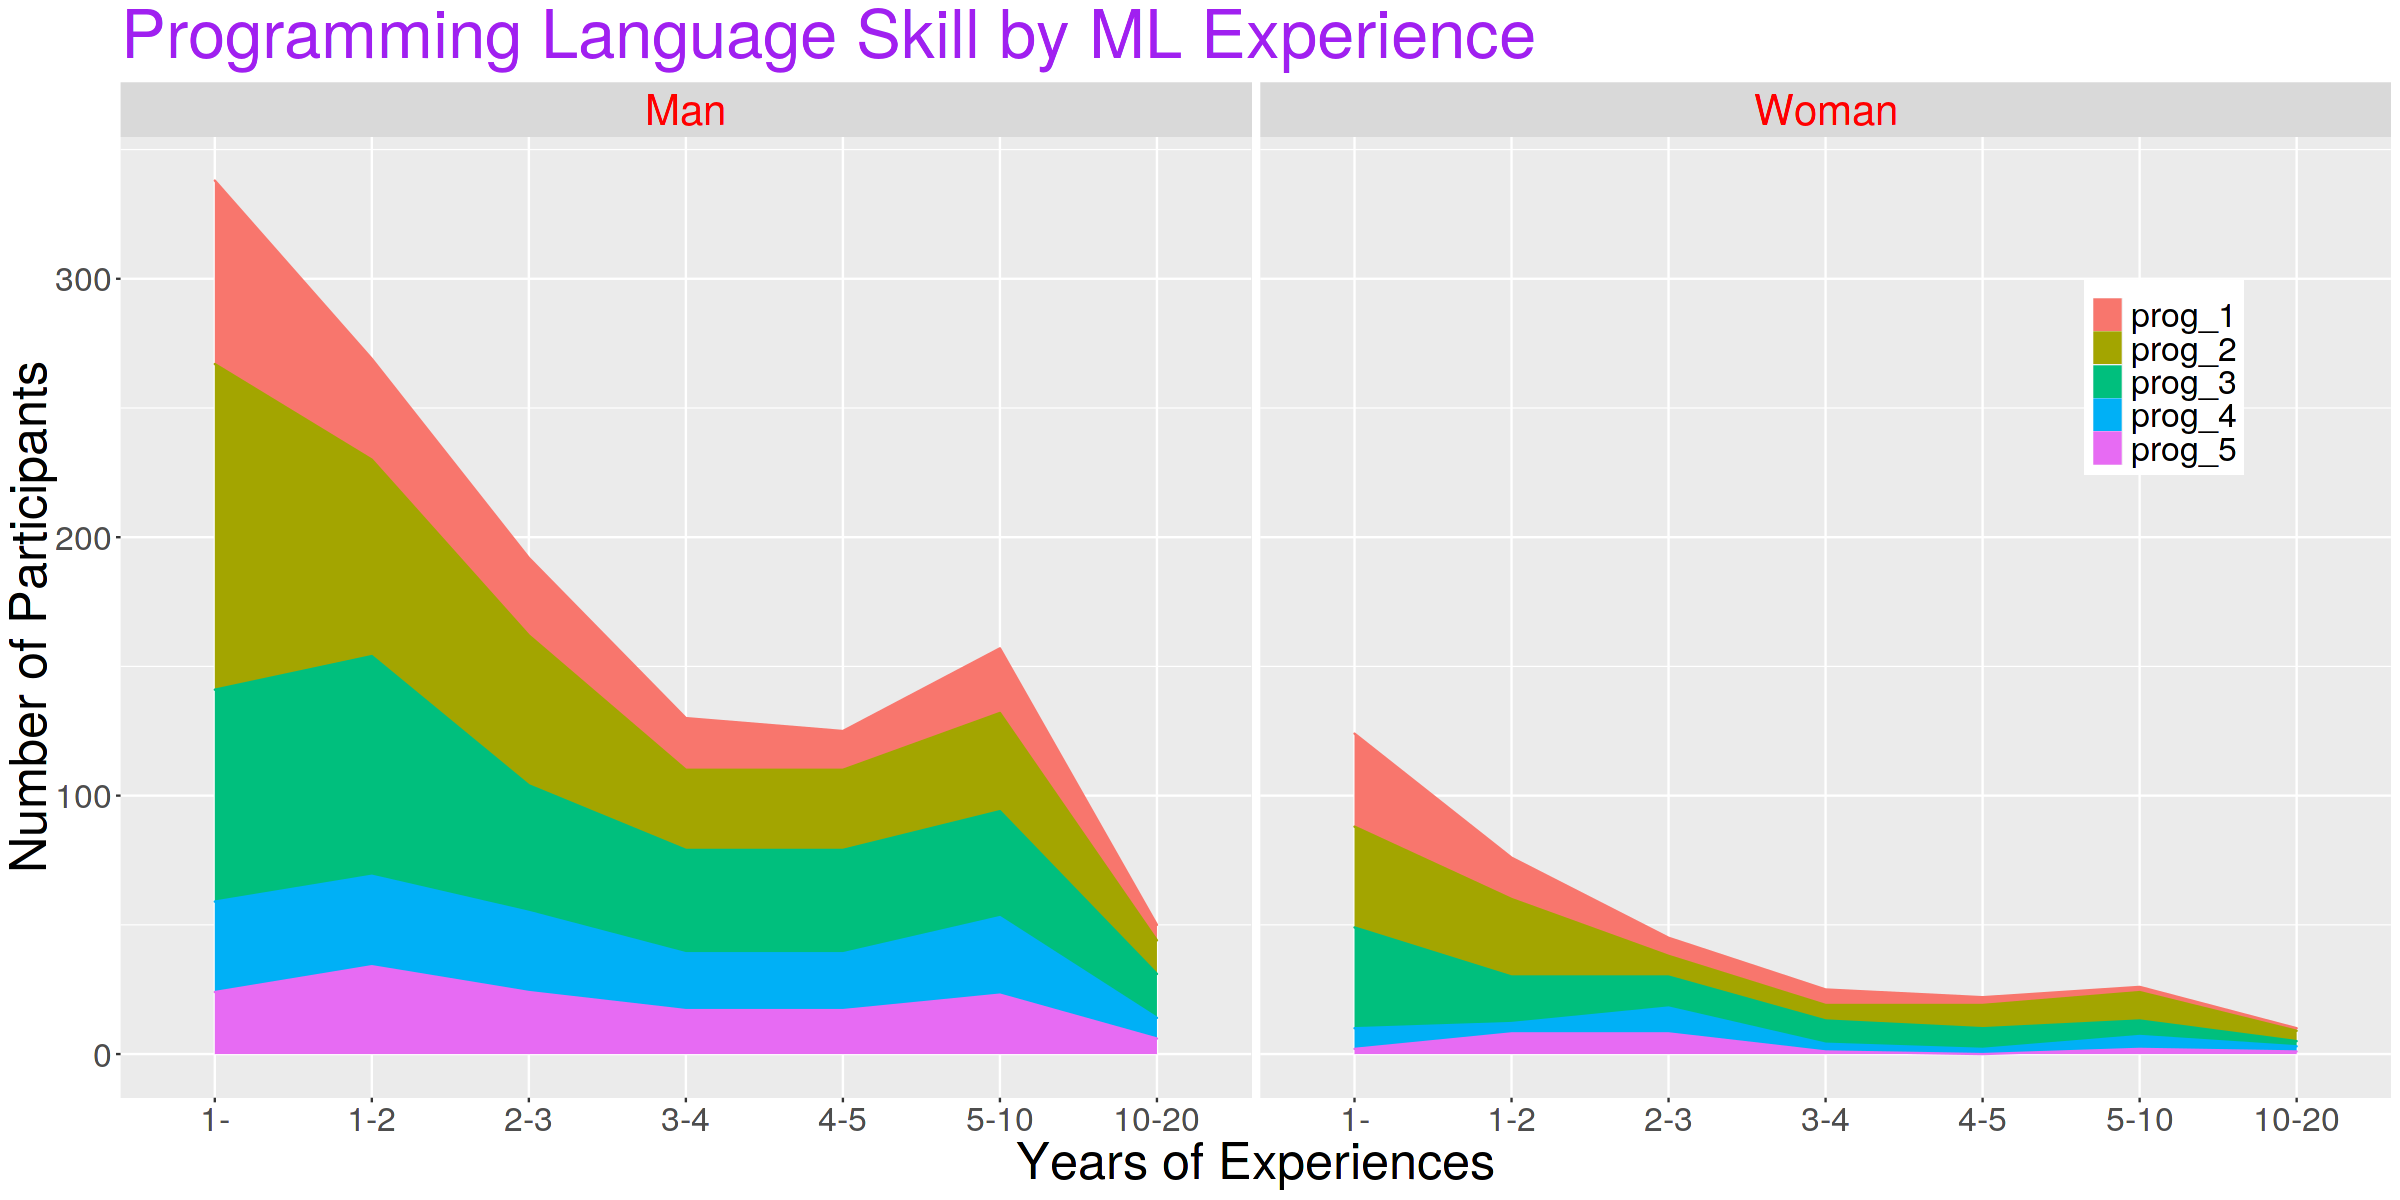

In [33]:
################################
##US survey participants 
##################################

#Coding Skill of US Participants
US_coding_ml_exp<- (dat2
                    %>% filter(country == "USA")
                    %>% mutate(prog_all = (Q7_Part_1.Python+Q7_Part_2.R+Q7_Part_3.SQL+Q7_Part_4.C+
                                   Q7_Part_5.C..+Q7_Part_6.Java+Q7_Part_7.Javascript+Q7_Part_8.Julia+
                                   Q7_Part_9.Swift+Q7_Part_10.Bash+Q7_Part_11.MATLAB+Q7_Part_12.None+Q7_OTHER.Other),
                              prog_1 = ifelse(prog_all == 1, 1, 0),
                              prog_2 = ifelse(prog_all == 2, 1, 0),
                              prog_3 = ifelse(prog_all == 3, 1, 0),
                              prog_4 = ifelse(prog_all == 4, 1, 0),
                              prog_5 = ifelse(prog_all > 4, 1, 0))
                    %>% filter(Q15 !="I do not use machine learning methods" & Q15 != "")
                    %>% mutate(ml_exp = ifelse(Q15 == "Under 1 year", "1-",
                                               ifelse(Q15 == "1-2 years", "1-2", 
                                                      ifelse(Q15 == "2-3 years", "2-3",
                                                             ifelse(Q15 == "3-4 years", "3-4",
                                                                    ifelse(Q15 == "4-5 years", "4-5", 
                                                                           ifelse(Q15 == "5-10 years","5-10",
                                                                                  ifelse(Q15 == "10-20 years", "10-20", "20+"))))))))
                    %>% group_by(ml_exp, gender)
                    %>% summarize(prog_1 = sum(prog_1),
                                  prog_2 = sum(prog_2),
                                  prog_3 = sum(prog_3),
                                  prog_4 = sum(prog_4),
                                  prog_5 = sum(prog_5),
                                  .groups = 'drop')
                    %>% filter(gender %in% c("Man", "Woman") & ml_exp != "20+")
                    #%>% mutate(Q15 = ifelse(Q15 == "I do not use machine learning methods", "No ML Exp", as.character(Q15)) )
                  
)

#Area Plot 
US_coding_ml_exp<- melt(US_coding_ml_exp, id = c("ml_exp", "gender"))
US_coding_ml_exp$Num_prog<- US_coding_ml_exp$variable

US_coding_ml_exp %>%
  mutate(ml_exp = factor(ml_exp, level=c("1-", "1-2", "2-3", 
                              "3-4", "4-5", "5-10", "10-20")))%>% 
  ggplot(aes(x= ml_exp, y=value)) + 
  geom_area(aes(colour = Num_prog, group=Num_prog, fill = Num_prog))+
  labs(x="Years of Experiences",y="Number of Participants")+
  ggtitle("Programming Language Skill by ML Experience") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
    theme(legend.title = element_blank(),
          legend.position = c(0.90, 0.75),
          legend.text = element_text(size = 20))+
facet_grid(. ~gender)+
theme(strip.text.x = element_text(size = 25, colour = "red"))

<div style="text-align: justify;
       font-size:20px">
Majority of data scientist with masters degree are in age range of 24-39 for both genders. Data scientist with doctorate degree are majority in 40-44 and 50-54 age group for men, and 40-44 for women.
    <br>
    <br>
Interestingly, among participants with bachelors degree, women data scientist are in all age range from 18-69 whereas for men it is 18-54.
</div>

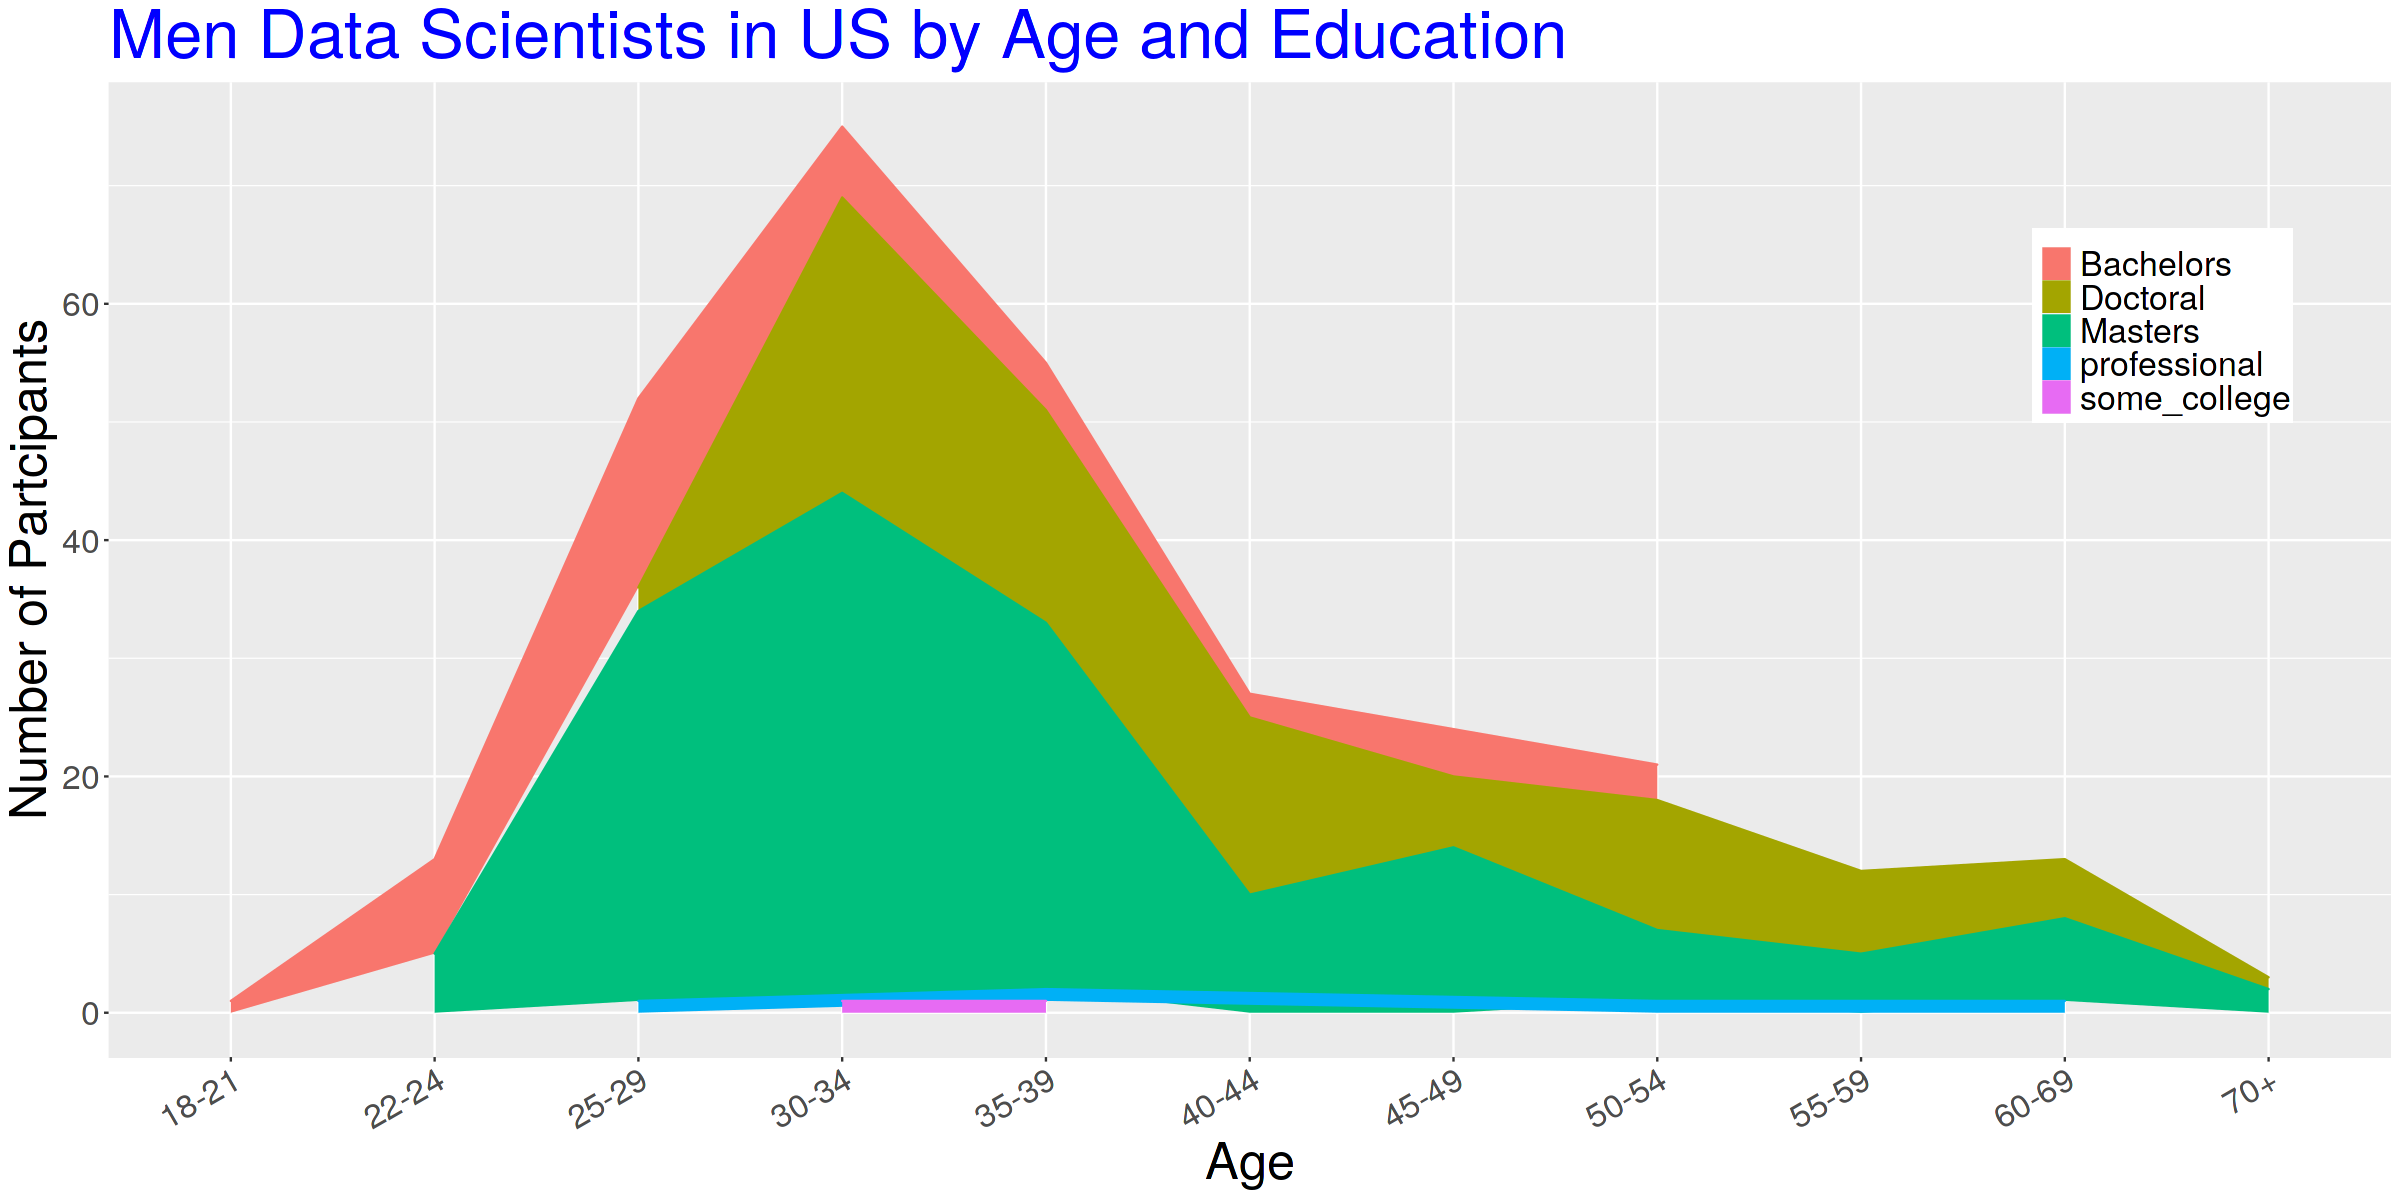

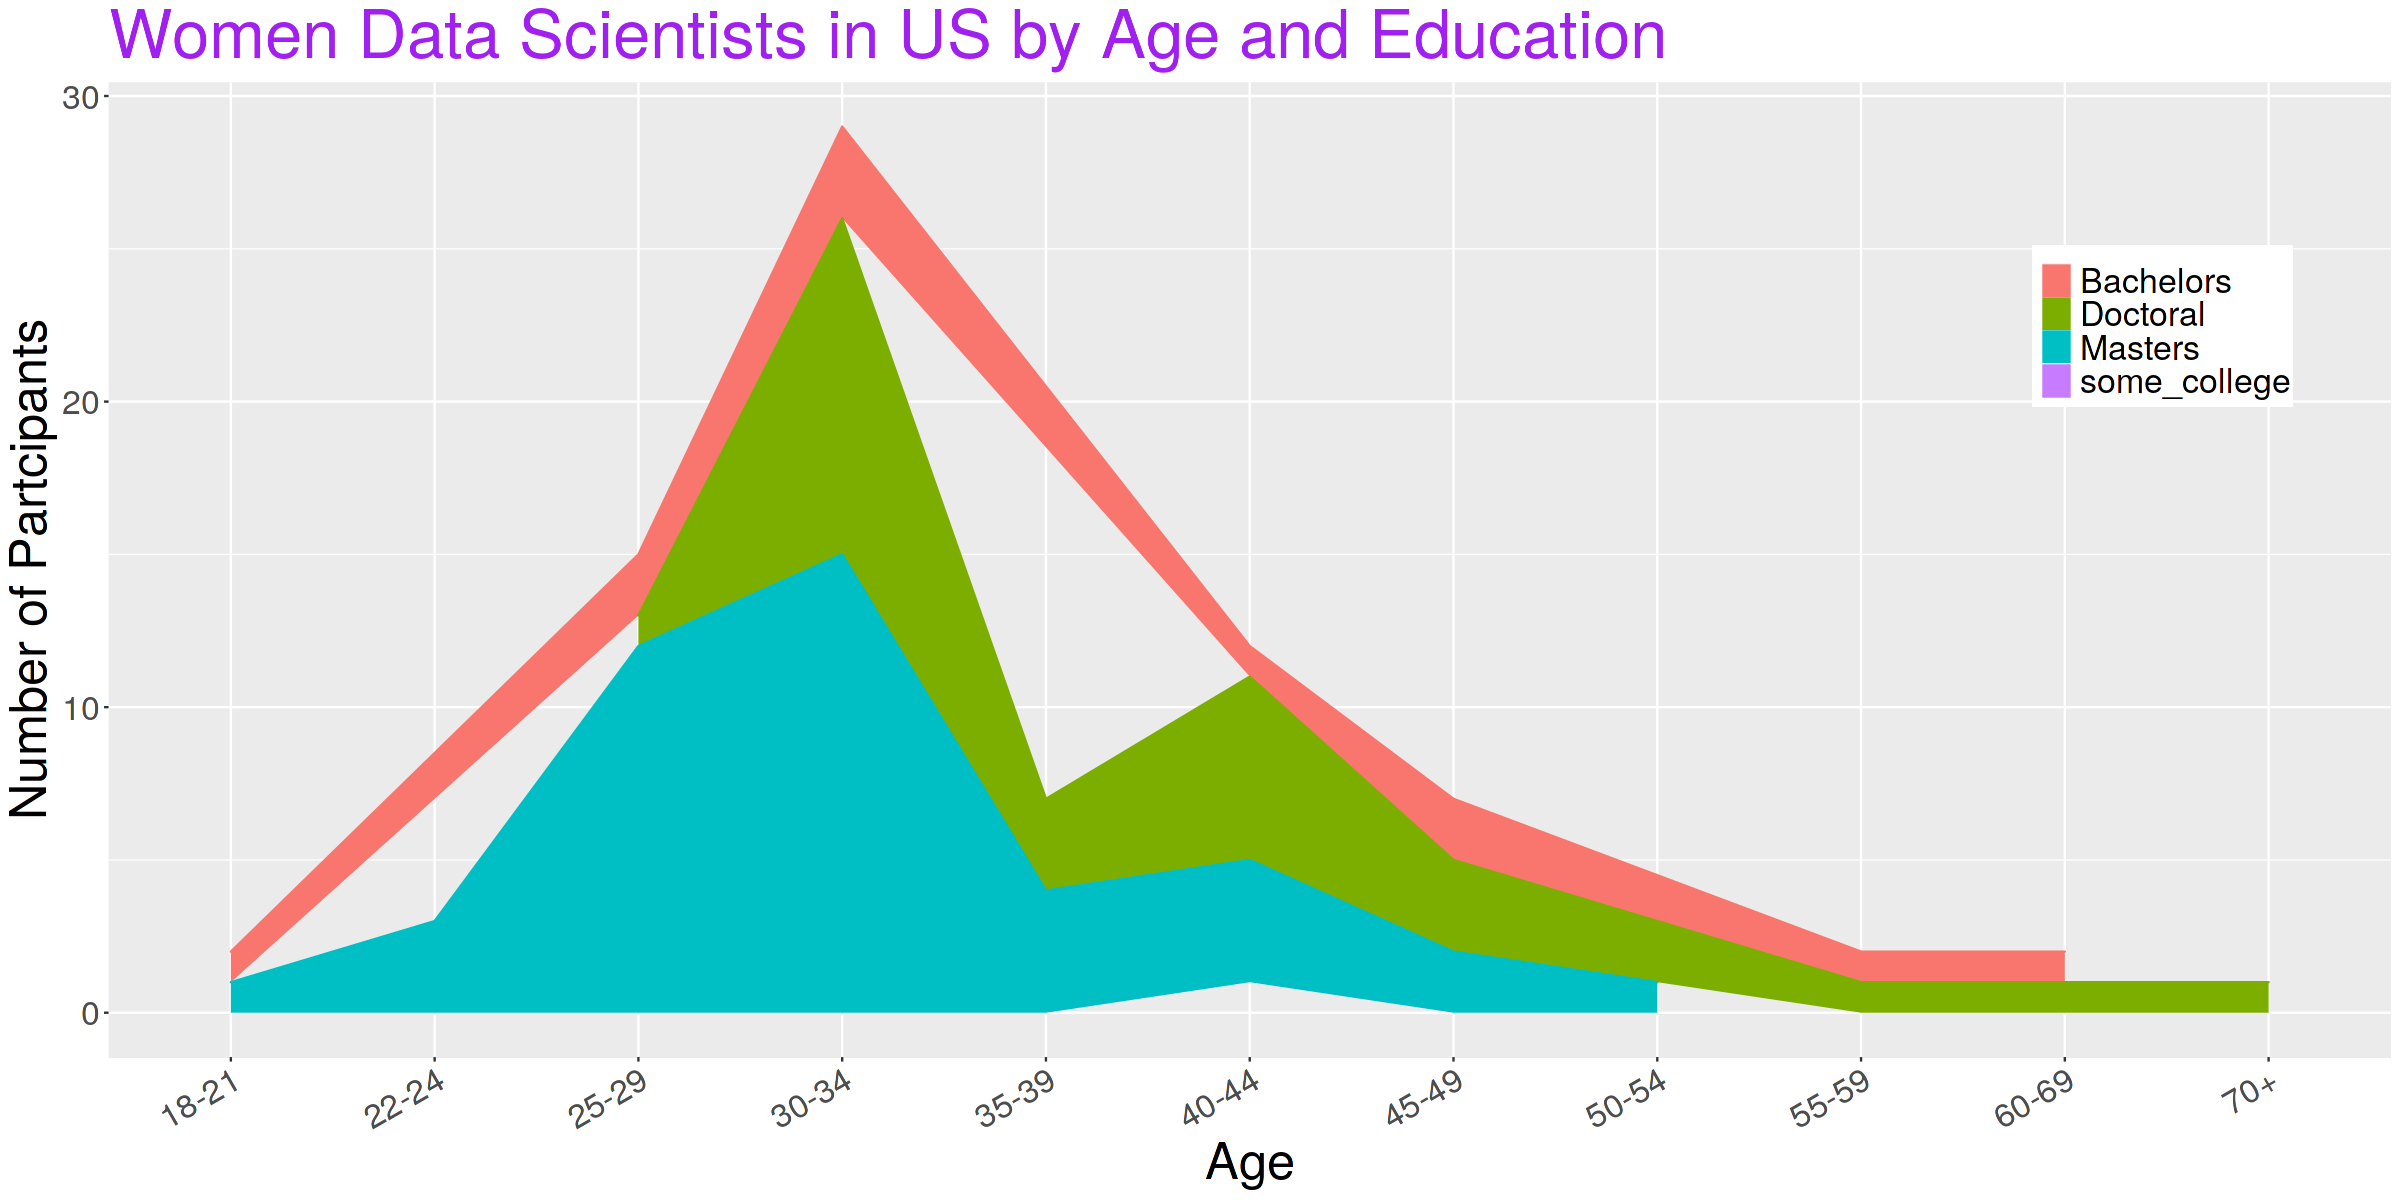

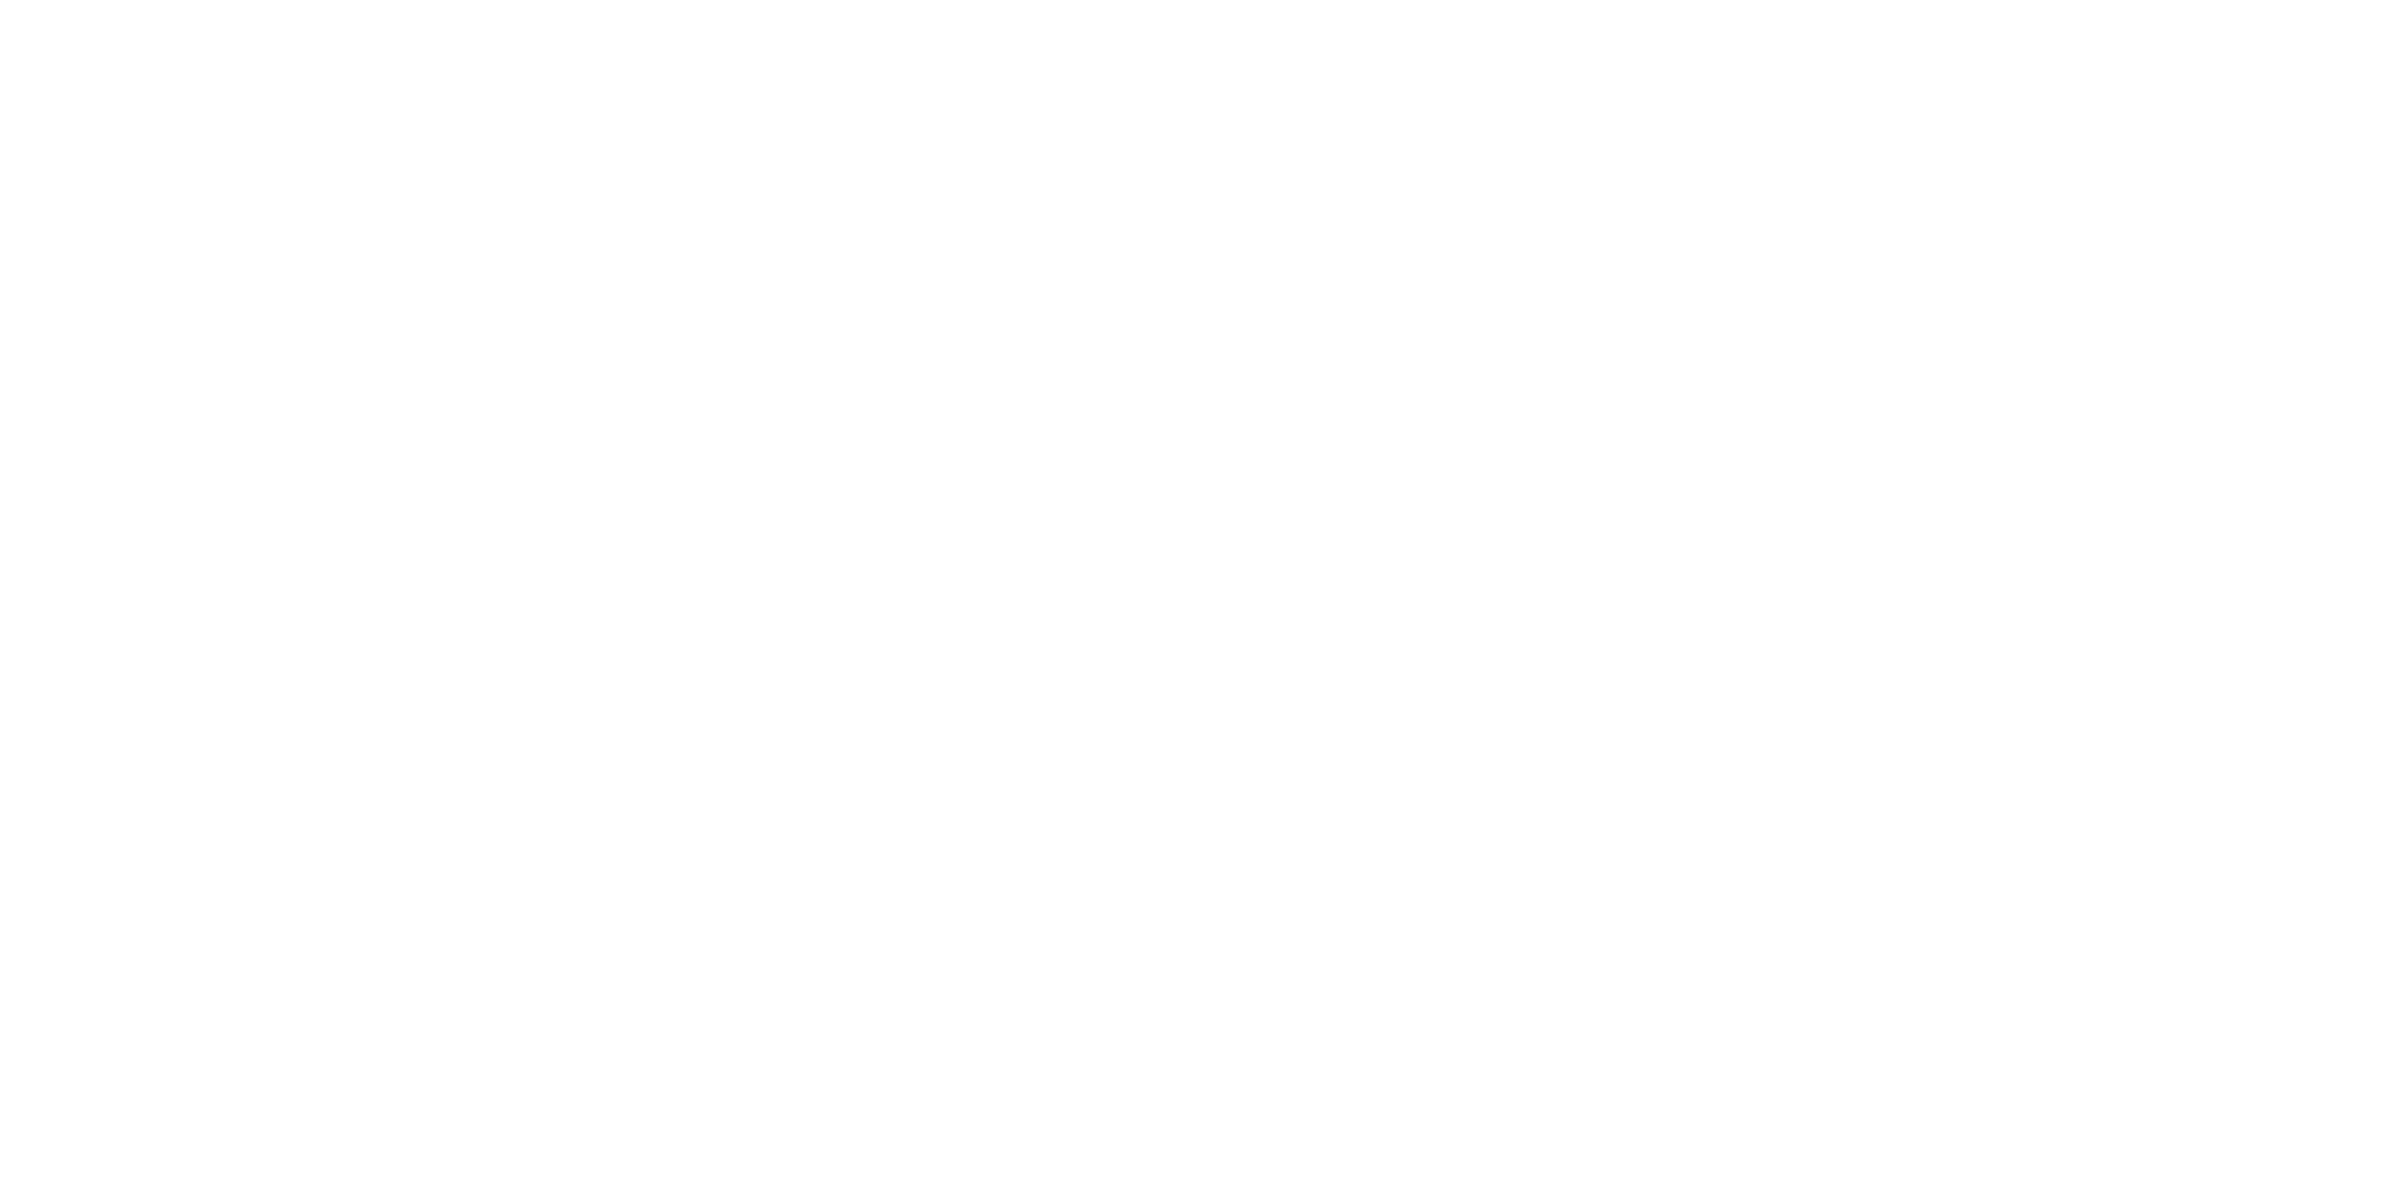

In [34]:
#Who are data scientist in the US
us_ds_m <- (dat2
          %>% filter(country == "USA" & current.role == "Data Scientist")
          %>% filter(gender=="Man")
          %>% group_by(Age, highest.edu)
          %>% summarize(num = n(), .groups = 'drop')
          
          )

us_ds_w <- (dat2
          %>% filter(country == "USA" & current.role == "Data Scientist")
          %>% filter(gender=="Woman")
          %>% group_by(Age, highest.edu)
          %>% summarize(num = n(), .groups = 'drop')
          
          )

#Area chart
us_ds_m %>% ggplot(aes(x= Age, y=num)) + 
  geom_area(aes(colour = highest.edu, group=highest.edu, fill = highest.edu))+
  labs(x="Age",y="Number of Partcipants")+
  ggtitle("Men Data Scientists in US by Age and Education") +
  theme(plot.title = element_text(size = 40, color = 'blue', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
    legend.position = c(0.90, 0.75),
    legend.text = element_text(size = 20),
    axis.text.x = element_text(angle = 30, hjust = 1))

us_ds_w %>% ggplot(aes(x= Age, y=num)) + 
  geom_area(aes(colour = highest.edu, group=highest.edu, fill = highest.edu))+
  labs(x="Age",y="Number of Partcipants")+
  ggtitle("Women Data Scientists in US by Age and Education") +
  theme(plot.title = element_text(size = 40, color = 'purple', family = 'Times new Roman'),
        axis.text.x = element_text(size = 20, family = 'Times new Roman'),
        axis.text.y = element_text(size = 20, family = 'Times new Roman'),
        axis.title.x = element_text(size = 30, family = 'Times new Roman'),
        axis.title.y = element_text(size = 30, family = 'Times new Roman'))+
  theme(legend.title = element_blank(),
    legend.position = c(0.90, 0.75),
    legend.text = element_text(size = 20),
    axis.text.x = element_text(angle = 30, hjust = 1))

ggarrange(us_ds_m, us_ds_w,ncol = 2, nrow = 1)

# <span style='color:purple'> Conclusions </span>

<div style="text-align: justify;
       font-size:20px">
    Given the nature of survey questions, lots of information and patterns could be uncovered. Since we focused on a few hypothesis, we have reported a small fraction of features such as programming languages, machine learning experience, machine learning algorithms for all levels of education, age range, gender, professions and countries. Our attempt to investigate gender gap across the several levels potentially have some practical utility for future direction in data science. At the end, some additional light is shaded on the respondents from the United States with specific focus on gender. 
      
</div>